In [93]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda
import datetime
import salem
from salem import get_demo_file, DataLevels, GoogleVisibleMap, Map
import shapely.geometry as shpg
import glob
import pickle as pkl
import os
from scipy.stats import binned_statistic_2d
from scipy import stats


pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [131]:
MREGIONS = {'WAf' : [[-18,25,4,25], 'spac', 0, (1,7), (8,12), (1,12), '925_650'], # last is hourly offset to UCT # 12    # [-18,25,4,25]
 'SAf' : [[20,35, -35,-15], 'spac', 2, (9,12), (1,5), (1,12) , '850_650'], # 10
 'india' : [[70,90, 5,30], 'asia', 5, (1,7), (8,12), (1,12) , '925_650'], # 7
 'china' : [[105,115,25,40], 'asia', 8 , (1,7), (8,12), (1,12), '925_650'], # 4
 'australia' : [[120,140,-23, -11], 'asia', 9, (10,12), (1,5), (1,12), '925_650'], # 3
 'sub_SA' : [[-68,-47, -40, -20.5], 'spac', -4, (9,12), (1,5), (1,12), '925_850'] , # 16
# 'trop_SA' : [[-75, -50, -20, -5], 'spac', -5, (1,12), (1,12), (1,12)], # 17
# 'GPlains' : [[-100,-90,32,47], 'nam', -6, (1,7), (8,12), (1,12), '925_650'] # # 18

}

In [58]:
rdics = {}
for regs in MREGIONS.keys():
    for ids, y in enumerate(range(2012,2018)):
        #'ipdb.set_trace()
        test = pd.read_csv(glob.glob('/media/ck/LStorage/global_water/ERA5_MCS_saveFiles/'+regs+'_ERA5_2012-2019_MCSTRACK_localBulk*_'+str(y)+'_h18_SUMMER.csv')[0])
        if ids == 0:
            test2 = pd.DataFrame(test)
        else :
            test2 = pd.concat([test2, test])
    rdics[regs] = test2

In [89]:
rdics.keys()

dict_keys(['WAf', 'SAf', 'india', 'china', 'australia', 'sub_SA', 'GPlains'])

In [ ]:
for regs in MREGIONS.keys():
    dat = rdics[regs]
    posi = np.abs(dat['tgrad2m']) > 1
    rdics = rdics[regs]

In [141]:
rdics['GPlains'].keys()

Index(['hour', 'month', 'year', 'day', 'date', 'core_area', 'ccs_area',
       'pf_area', 'lon', 'lat', 'clon', 'clat', 'direction', 'init_lon',
       'init_lat', 'tmin', 'tmean_core', 'tmean_ccs', 'tcwv', 'tgrad2m',
       'tgrad925', 'pmax', 'pmean', 'q925', 'q650', 'q850', 'u925', 'u650',
       'v925', 'v650', 'w925', 'w650', 'rh925', 'rh650', 't925', 't650',
       'div925', 'div850', 'div650', 'pv925', 'pv650', 'ushear925_650',
       'ushear850_650', 'ushear925_850', 'vshear925_650', 'vshear850_650',
       'vshear925_850', 'shear925_650', 'shear850_650', 'shear925_850', 'cape',
       't2m'],
      dtype='object')

<AxesSubplot:ylabel='Frequency'>

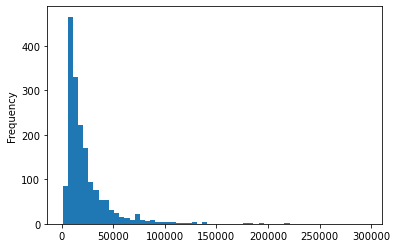

In [80]:
(rdics['WAf'])['pf_area'].plot.hist(bins=range(900,300000,5000))

In [82]:
len(rdics['australia'])

239

-0.3619299046069174 1.7911156397228185e-54
0.3304416850321737 4.853797112444306e-08
-0.4245868075761095 3.8822667364939663e-32
-0.6623455147607185 1.1251785617445802e-20
0.43055059604900514 3.3189377147038174e-12
0.4270654256300394 4.773122852042386e-20


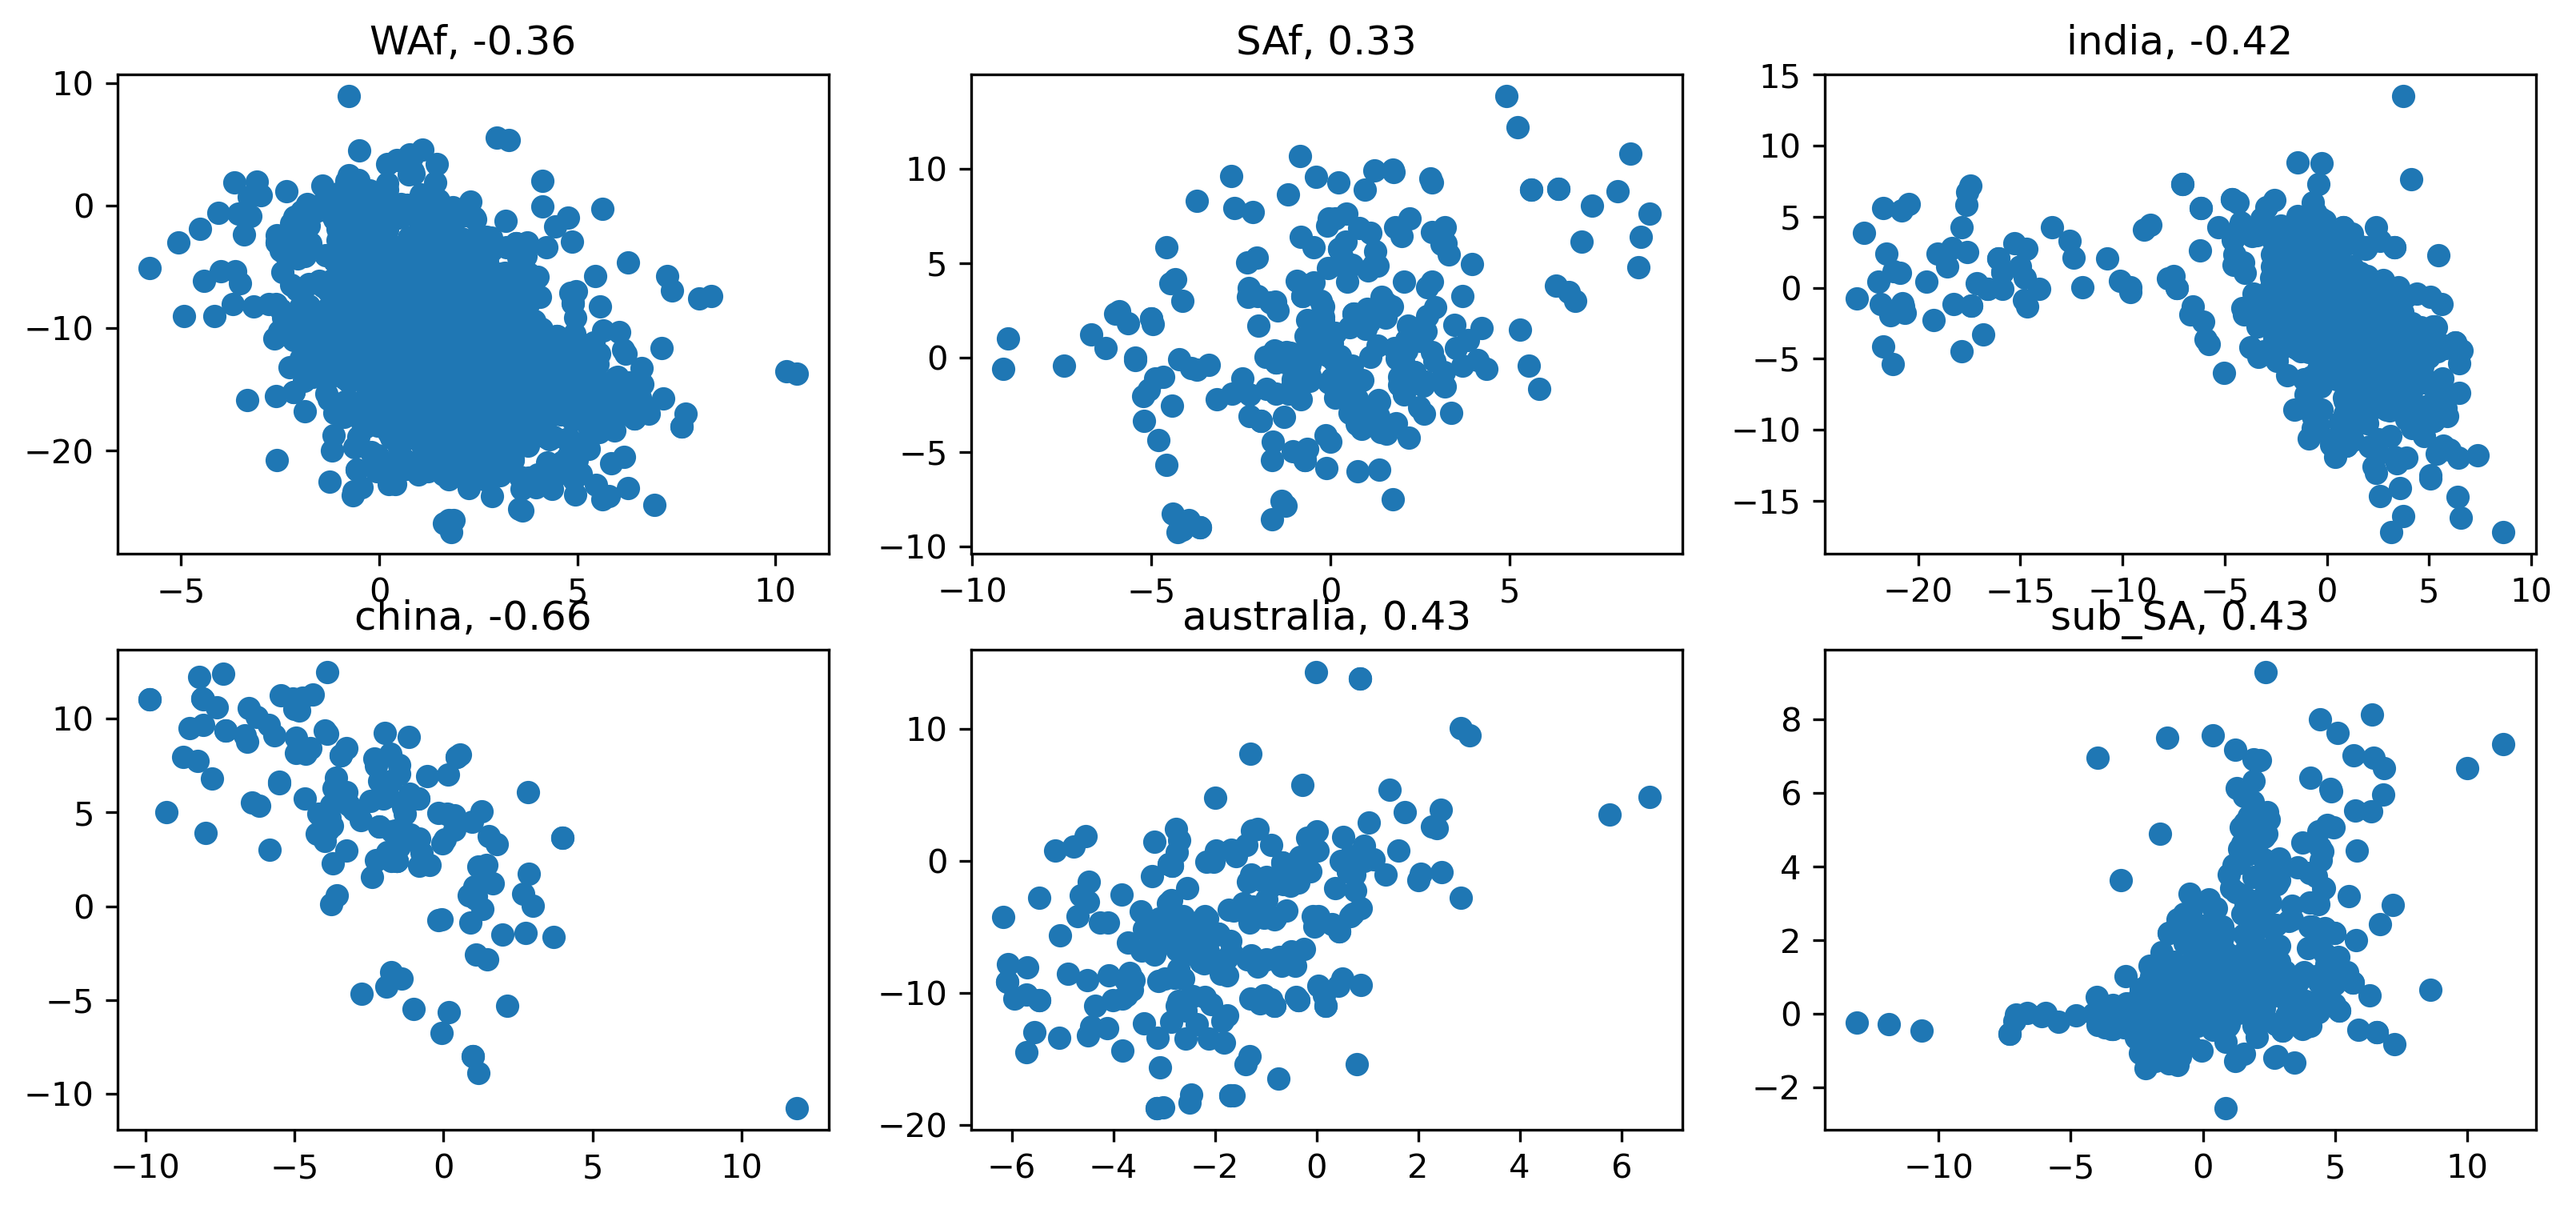

In [138]:
f= plt.figure(figsize=(13,9), dpi=300)

for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1)
    a = rdics[regs]['tgrad2m']
    tag = MREGIONS[regs][6]
    b = rdics[regs]['ushear'+tag]
    plt.scatter(a, b)
    r, pval = stats.pearsonr(a,b)
    print(r, pval)
    plt.title(regs+', '+str(np.round(r, 2)))

-0.02932131229654759 0.2238030198996278
0.013536252517231796 0.8280339499633551
-0.1847775031167354 8.096016356766969e-07
0.1304548778401978 0.107992750730355
0.03302926241817539 0.6113961119412966
-0.06175359018660971 0.20658704262183522


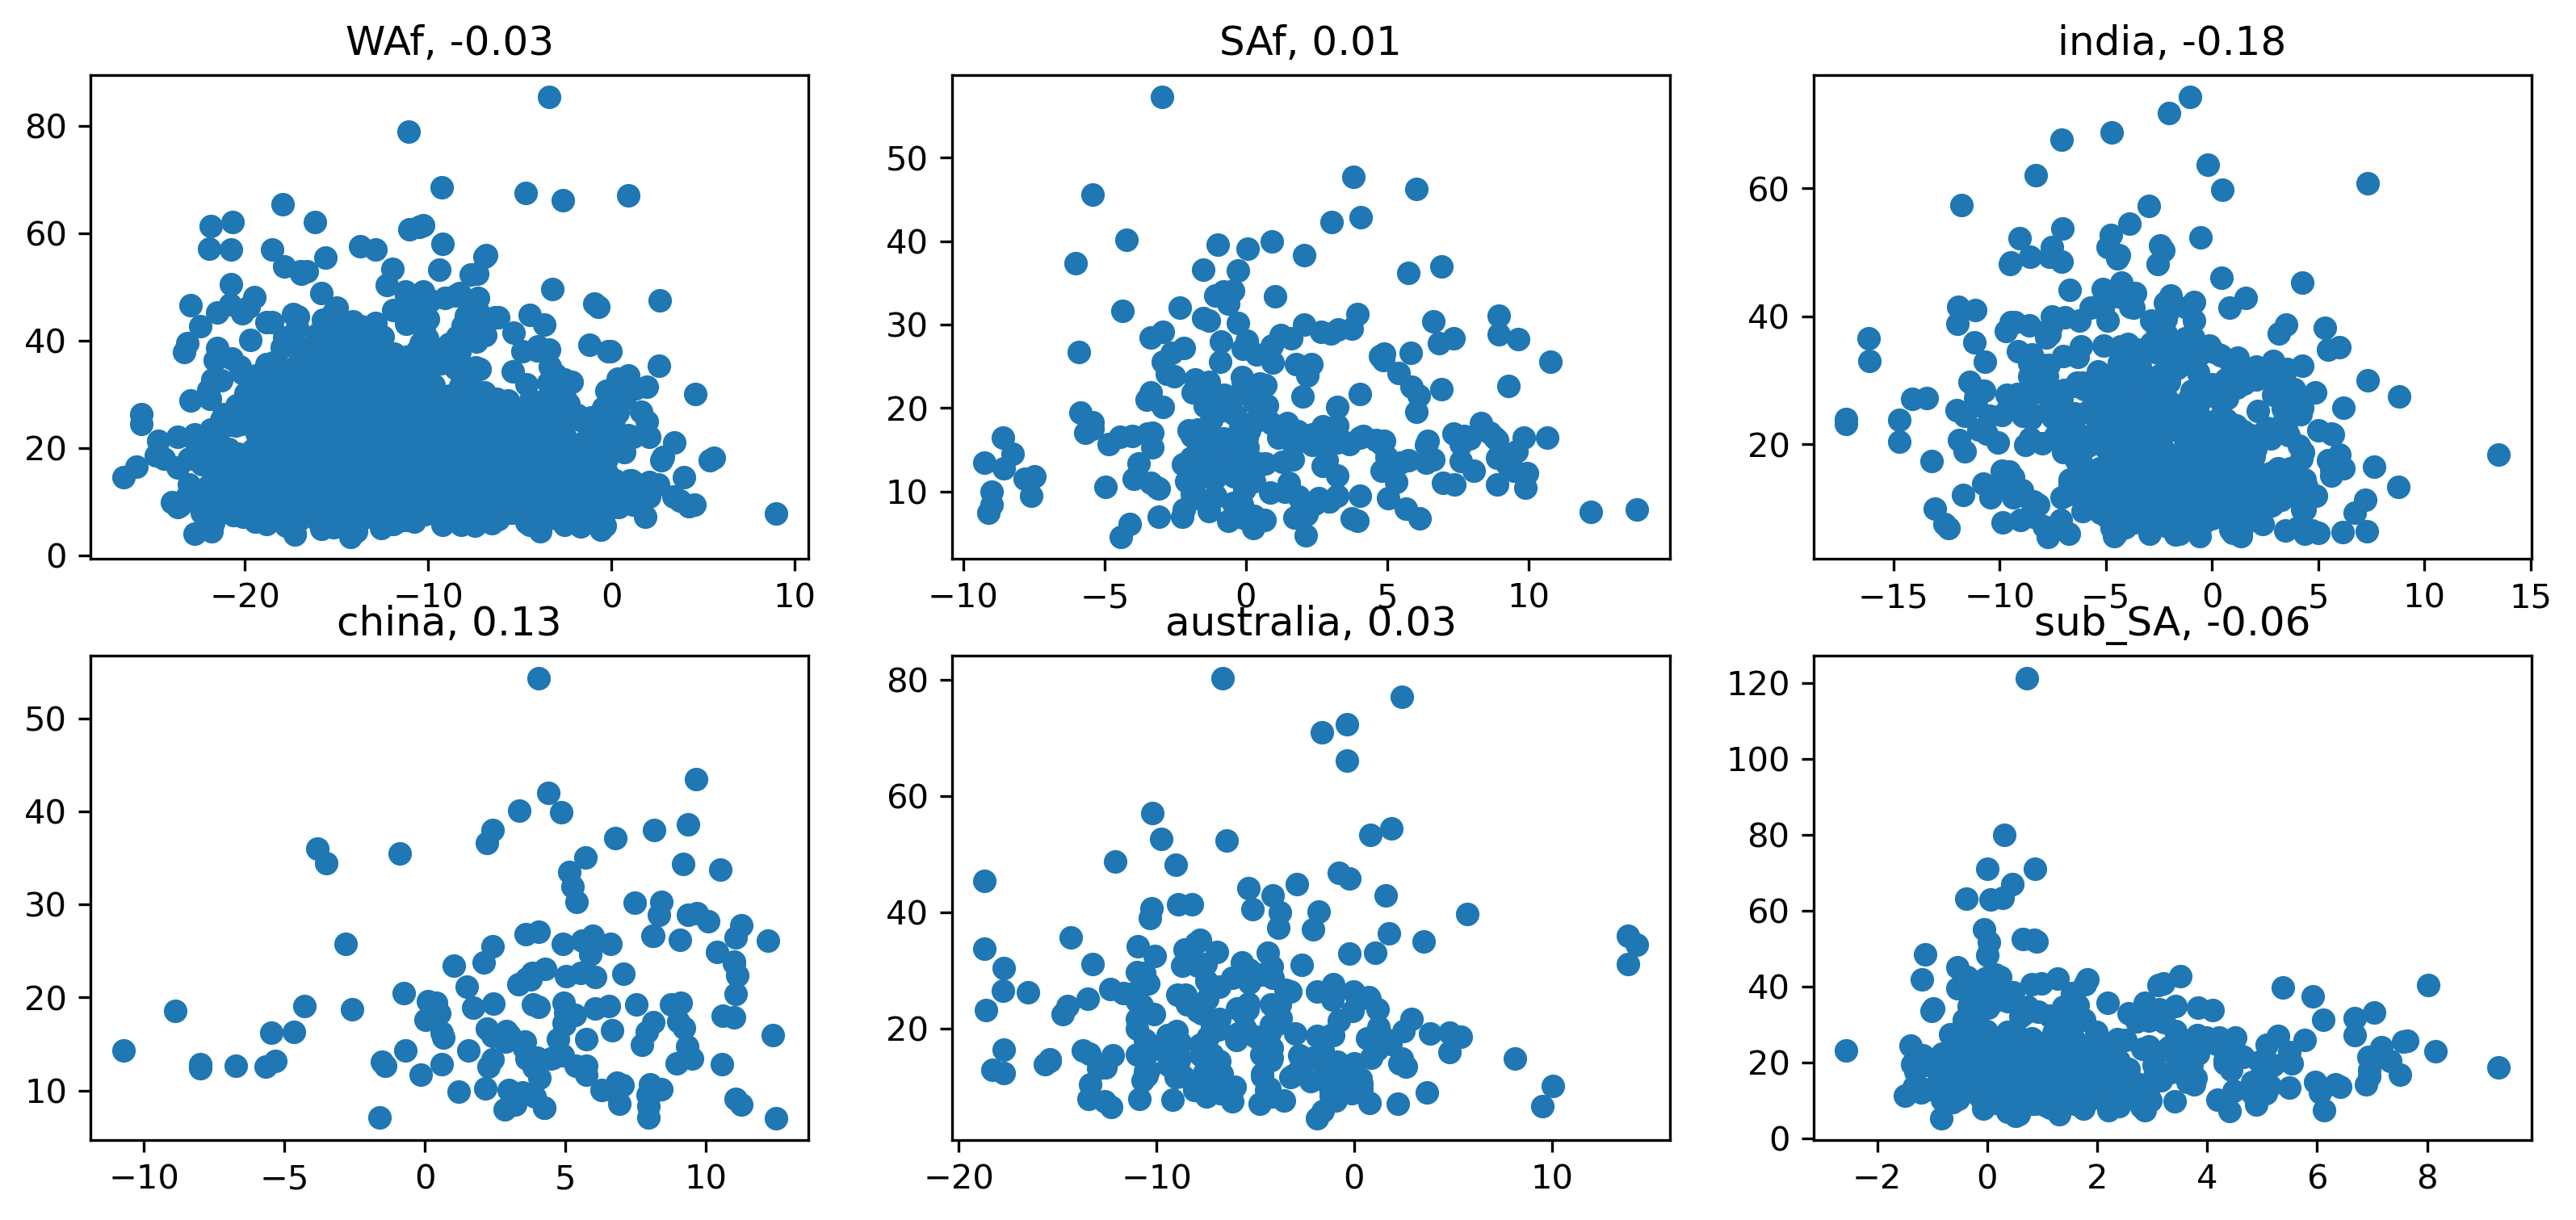

In [142]:
f= plt.figure(figsize=(13,9), dpi=300)

for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1)
    b = rdics[regs]['pmean']
    tag = MREGIONS[regs][6]
    a = rdics[regs]['ushear'+tag]
    plt.scatter(a, b)
    r, pval = stats.pearsonr(a,b)
    print(r, pval)
    plt.title(regs+', '+str(np.round(r, 2)))

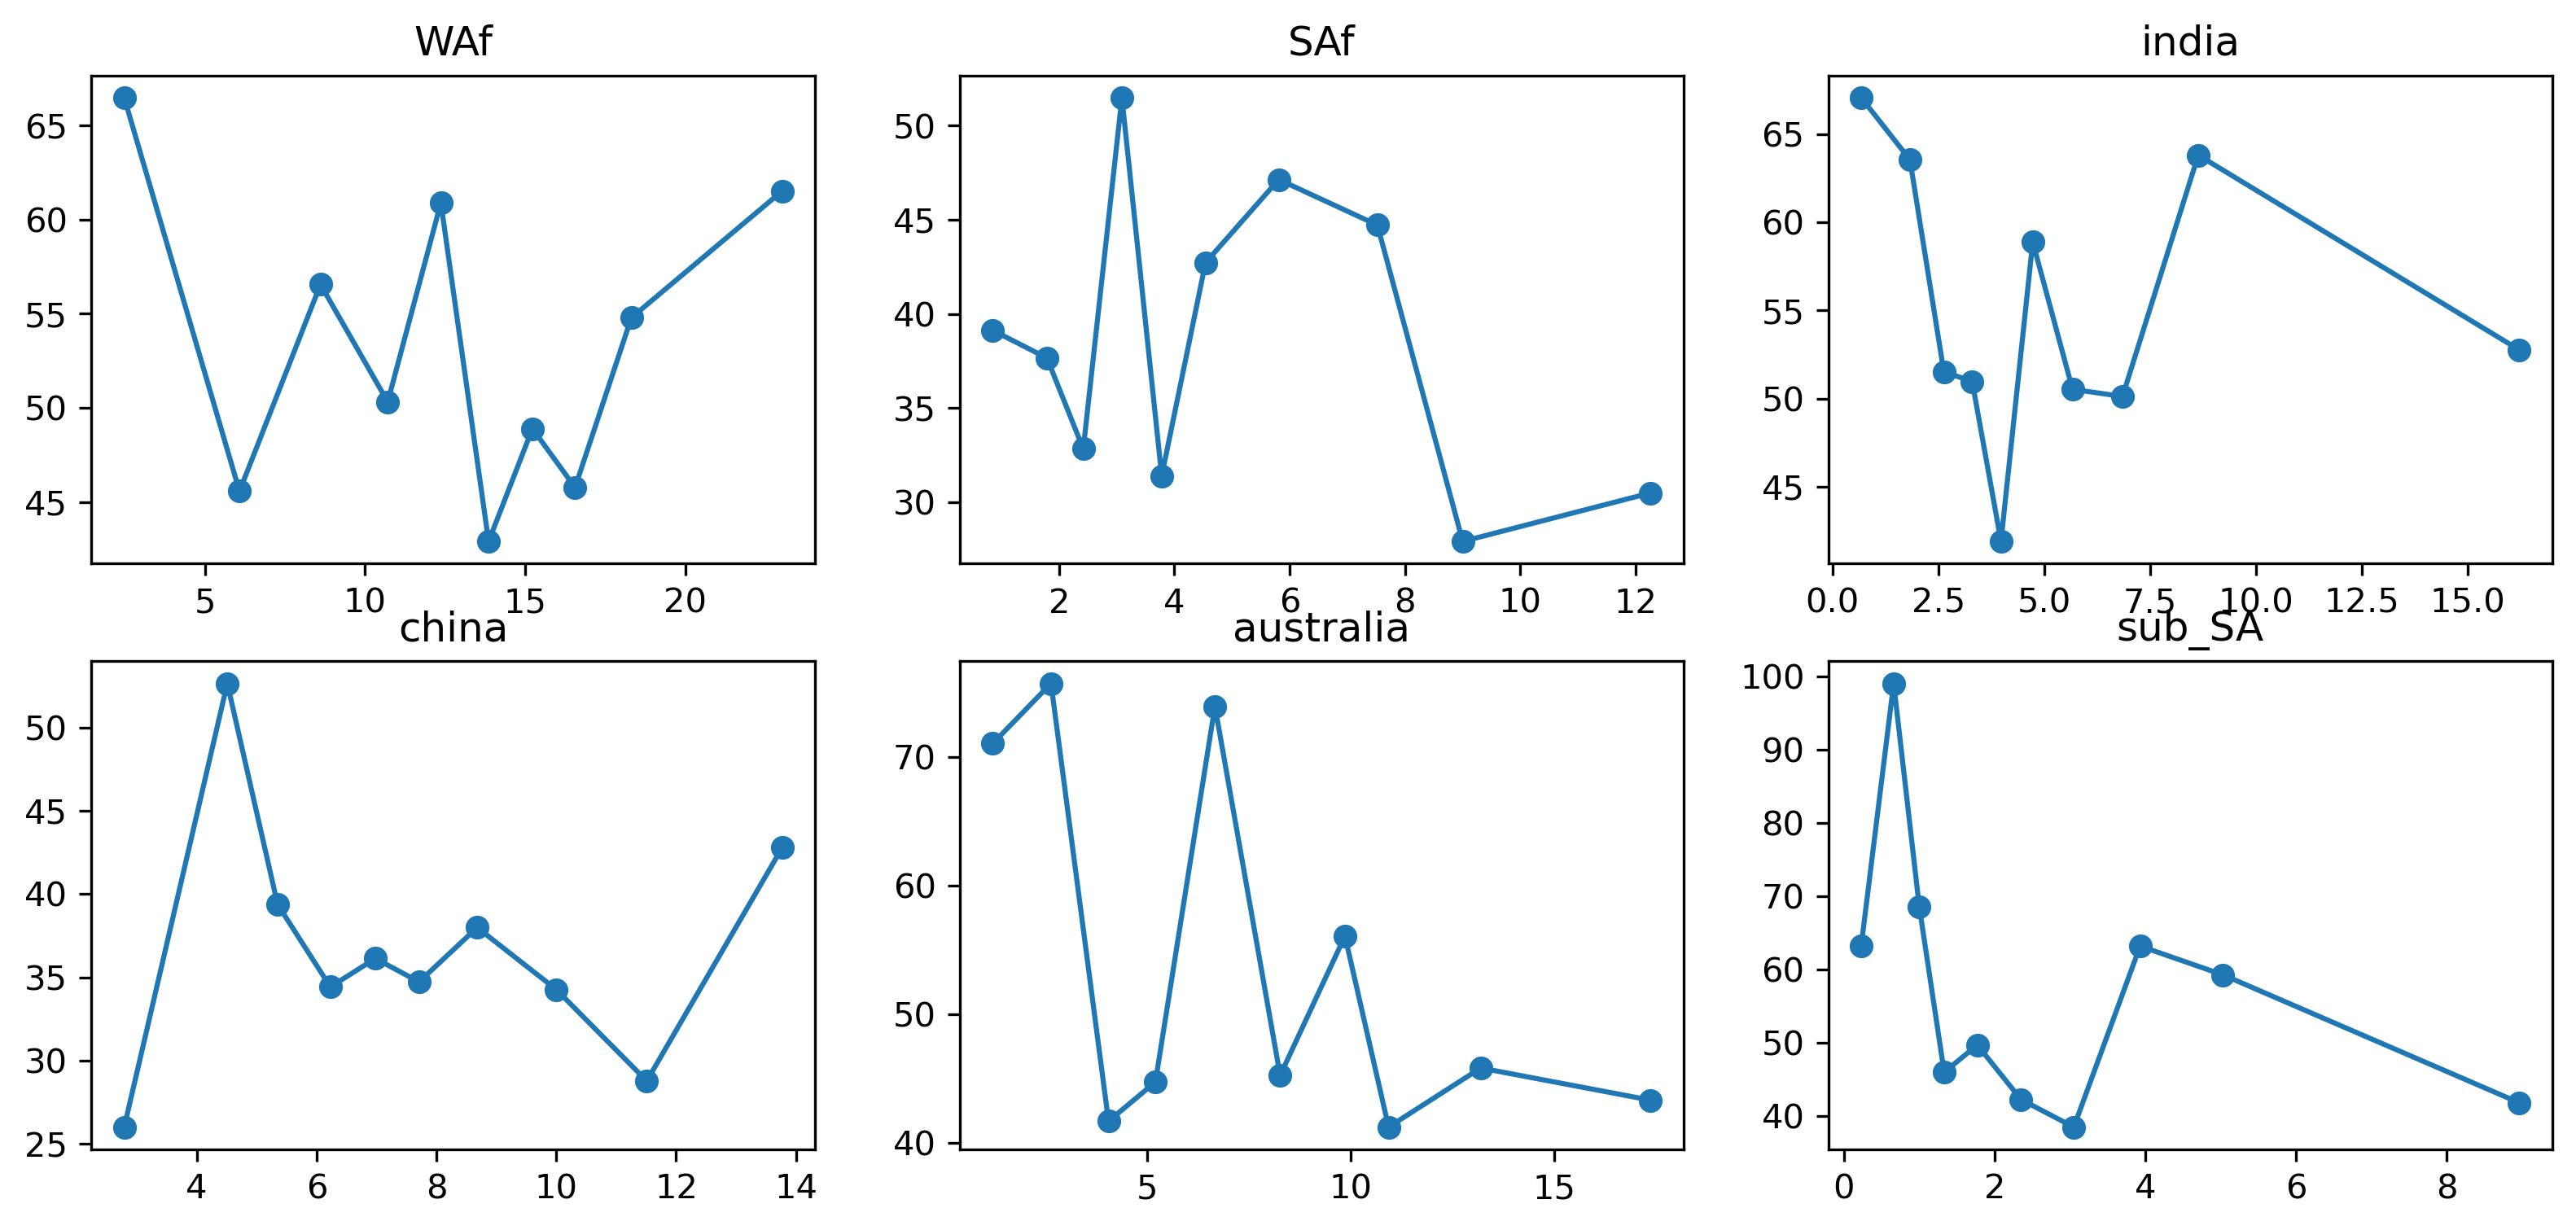

In [147]:
from endgame import hist2d
f= plt.figure(figsize=(13,9), dpi=300)

for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1)
    tag = MREGIONS[regs][6]
    var = 'shear'+tag
    outdic = hist2d.var2_binning_percentile(rdics[regs][var], rdics[regs]['pmax'], np.nanpercentile(rdics[regs][var],np.arange(0,101,10)), )
    plt.plot(outdic['xbins'], outdic['y'], '-o')
    plt.title(regs)

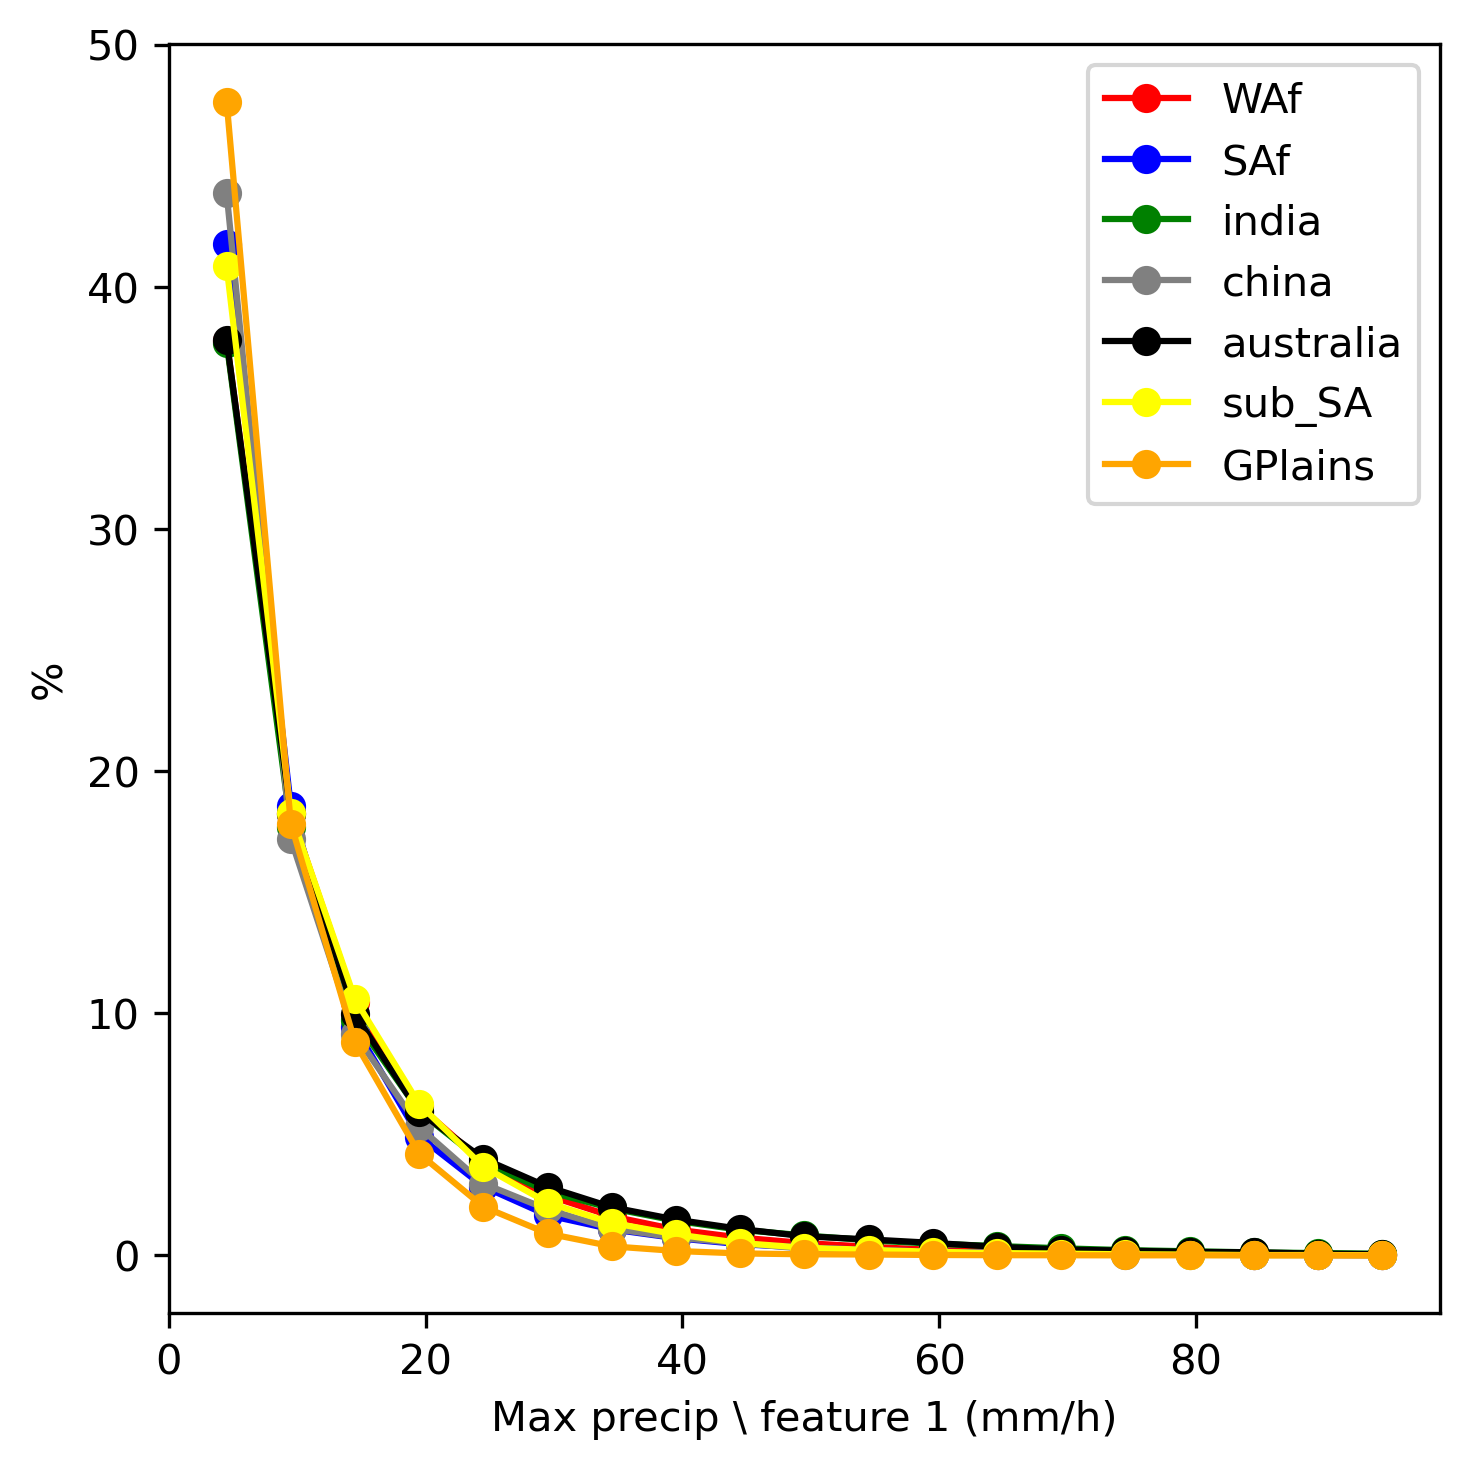

In [122]:
f= plt.figure(figsize=(5,5), dpi=300)
ax = f.add_subplot(111)
colors = ['r','b', 'g', 'grey', 'k', 'yellow', 'orange', 'purple']
for ids, regs in enumerate(MREGIONS.keys()):

    outdic = hist2d.basic_1d_binning((rdics[regs]['pf_maxrainrate2']).values, np.arange(2,100,5), percentage=True)
    #print(outdic.keys())
    plt.plot(outdic['xbins'], np.array(outdic['nb'])*100, '-o', color=colors[ids], label=regs)
    
    #ax.set_ylim(0,1)
    plt.ylabel('%')
    plt.xlabel('Max precip \ feature 1 (mm/h)')
plt.tight_layout()
plt.legend()
f.savefig('/home/ck/Desktop/lmcs/precip_feat1_dist.jpg')

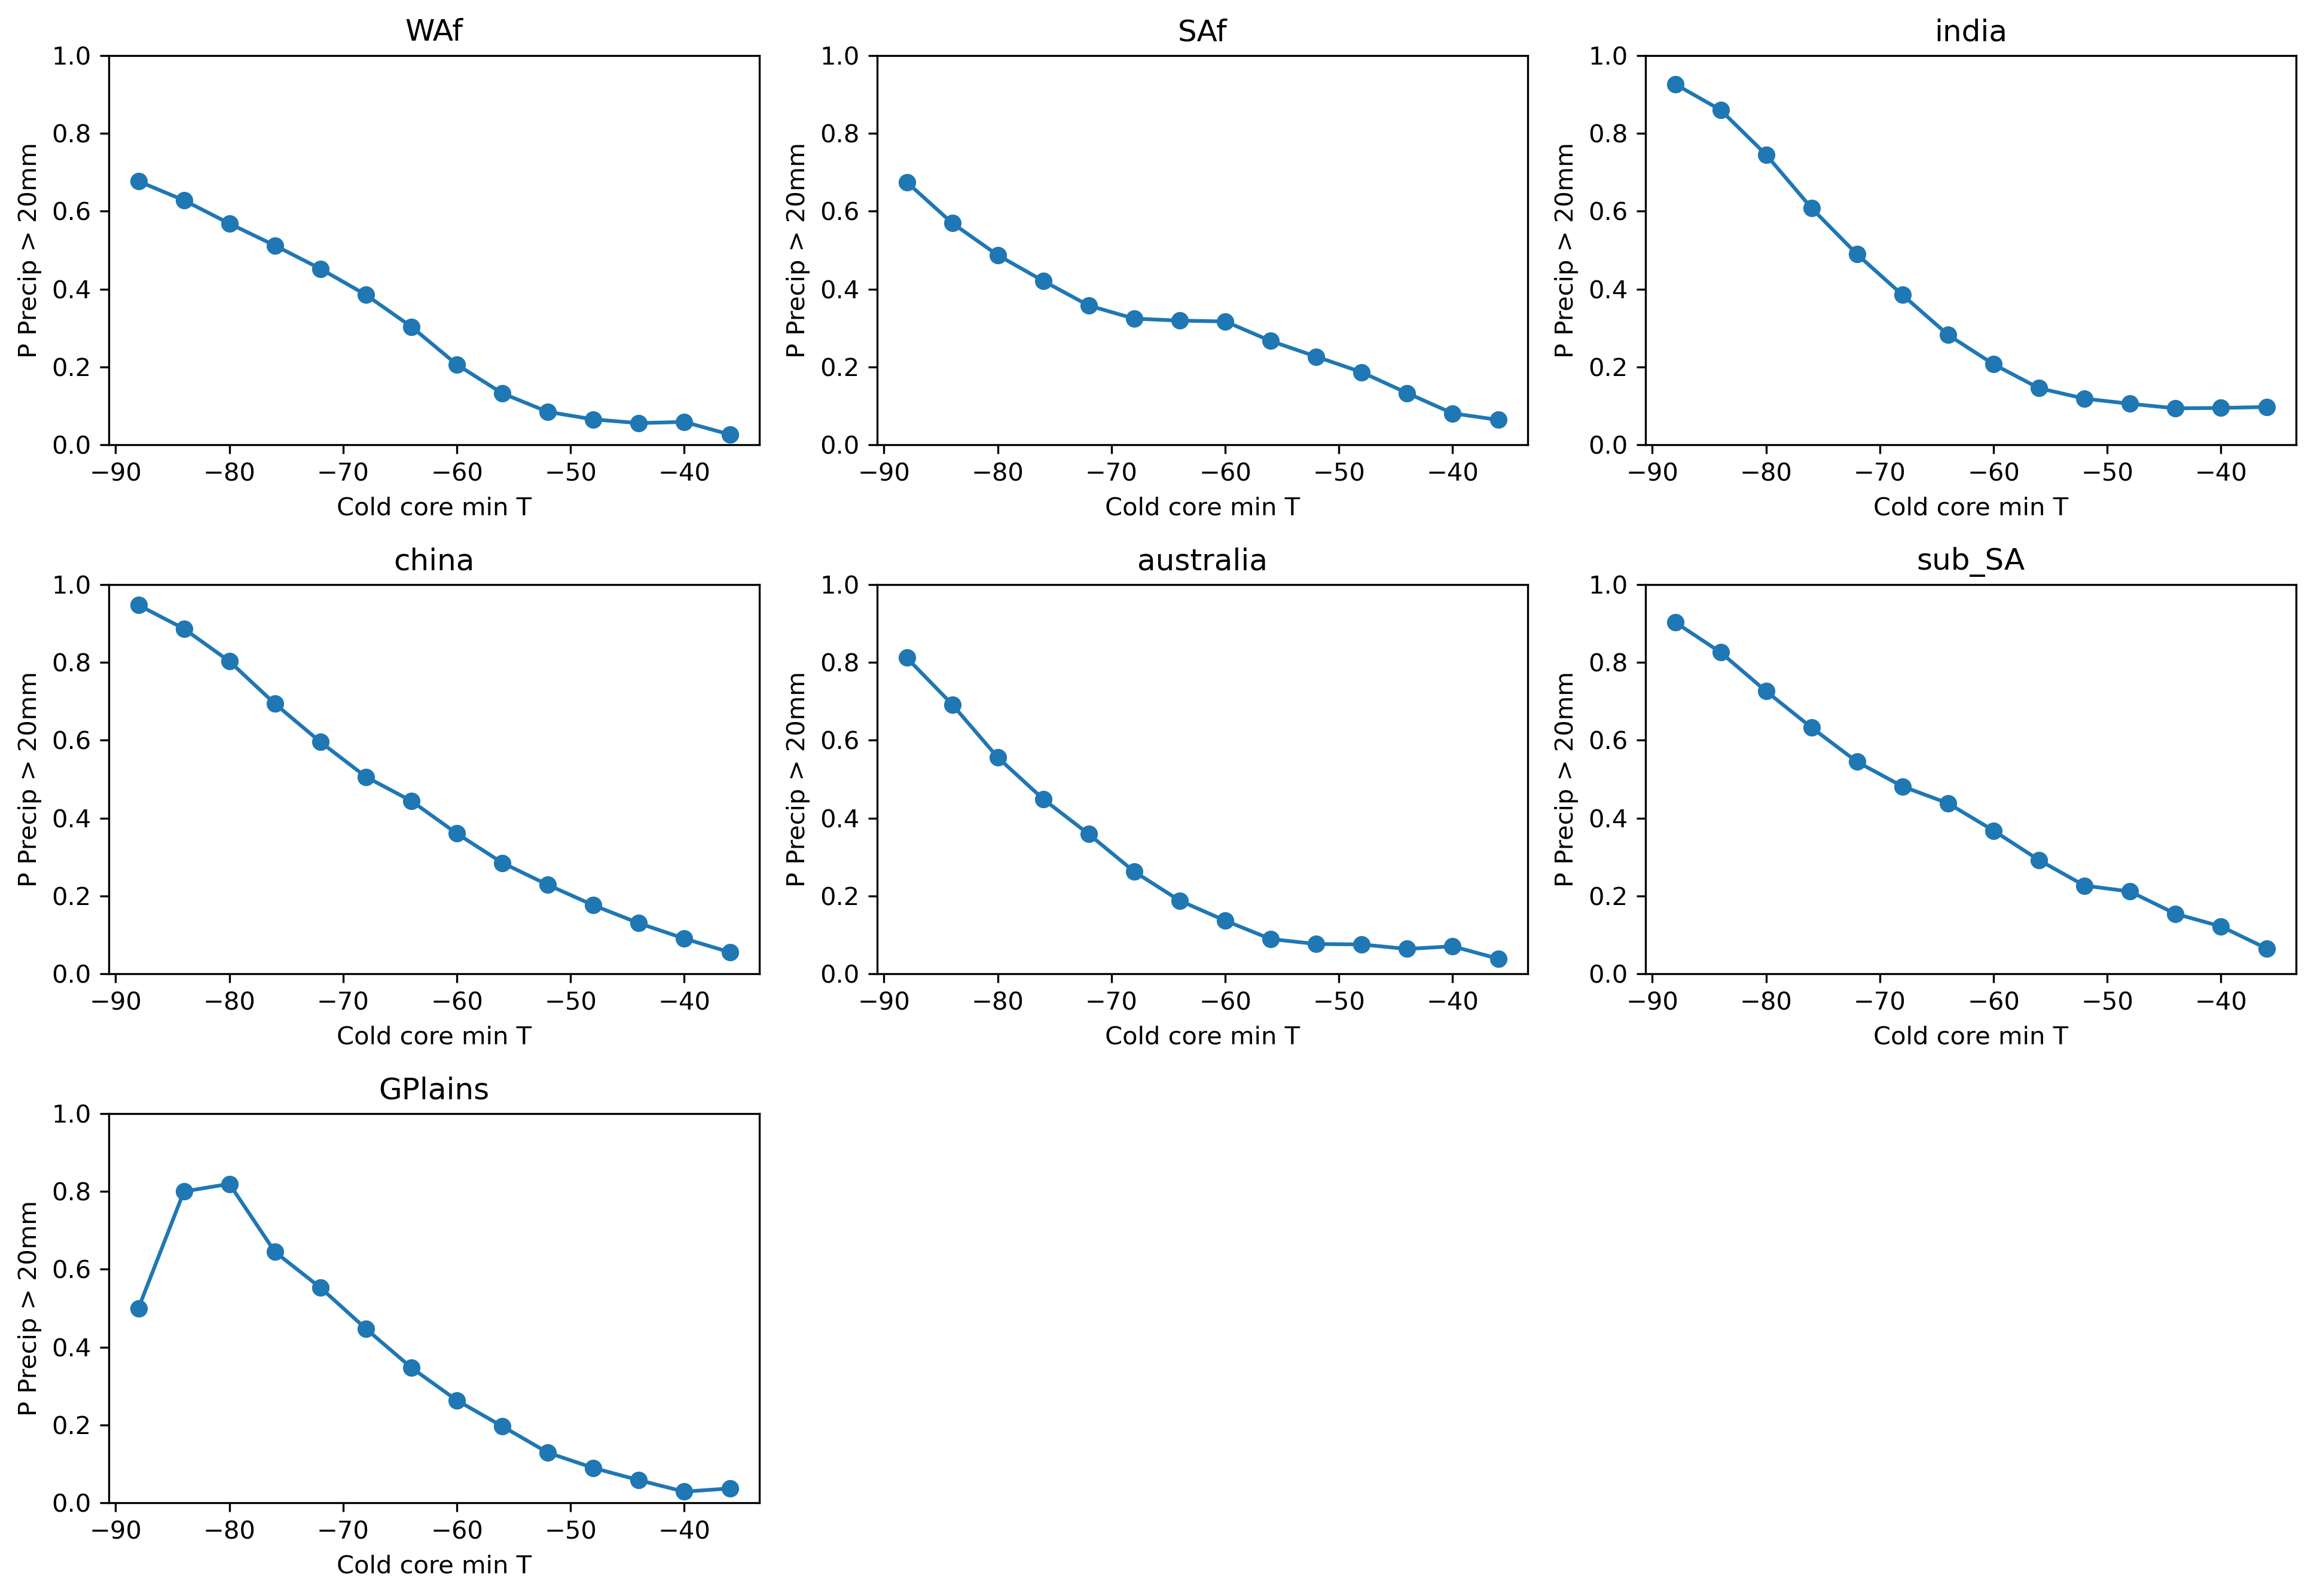

In [103]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1)
    outdic = hist2d.var2_binning_threshold((rdics[regs]['mintb']-273.15).values, (rdics[regs]['pf_maxrainrate1']).values, np.arange(-90,-30,4), gt=20)
    plt.plot(outdic['xbins'], outdic['y'], '-o')
    plt.title(regs)
    ax.set_ylim(0,1)
    plt.ylabel('P Precip > 20mm')
    plt.xlabel('Cold core min T')
plt.tight_layout()
f.savefig('/home/ck/Desktop/lmcs/20mm_precip_vs_CC_minT.jpg')

In [11]:
from utils import u_statistics as u_stats

18
16
13
10
9
22
24


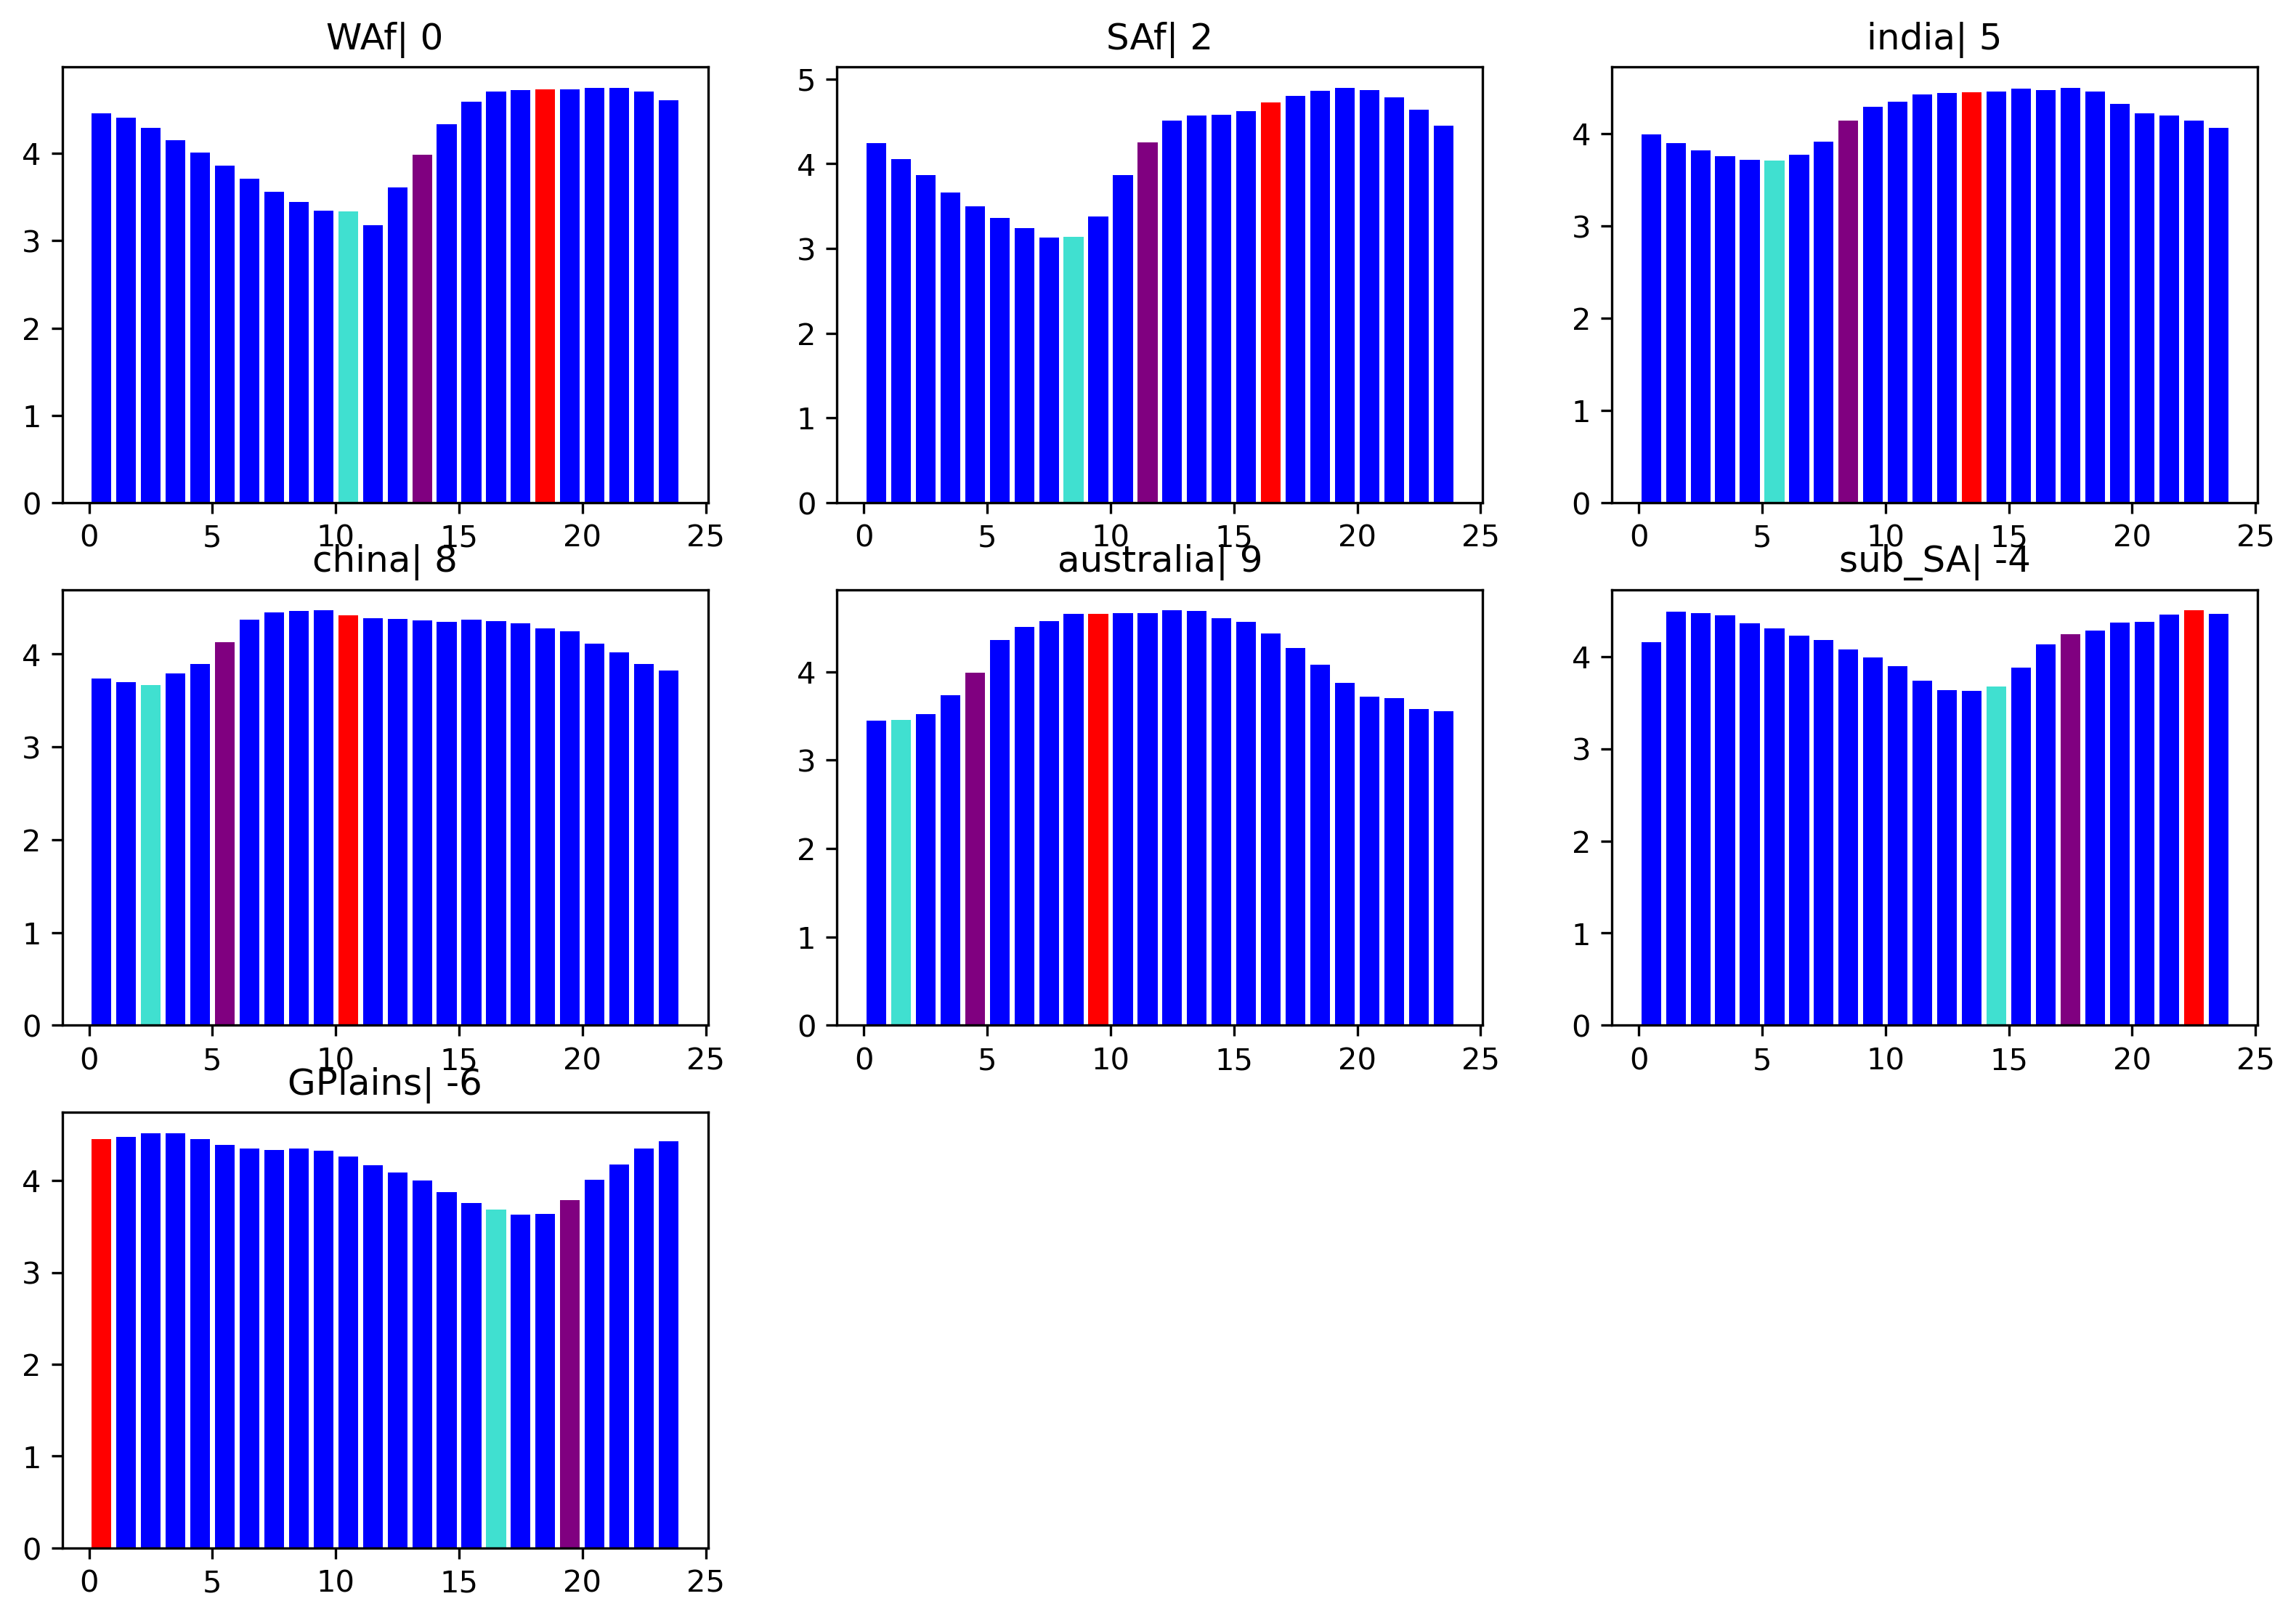

In [12]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    hist_freq, hist_count, bin_edge = u_stats.histo_frequency(pick['hour'], bins=np.arange(0,25))
    #print(np.unique(pick['hour']))
    mid_bin = bin_edge[0:-1] + (bin_edge[1::]-bin_edge[0:-1])/2
    #m_bin = mid_bin - (MREGIONS[regs])[2]
    #print(mid_bin)
    colors = ['b']*24
    ispos = int(np.where(mid_bin==18.5)[0])
    secpos = int(np.where(mid_bin==13.5)[0])
    firstpos = int(np.where(mid_bin==10.5)[0])
    #minpos = ispos-(MREGIONS[regs])[2]
    #ipdb.set_trace()
    minpos = ispos-(MREGIONS[regs])[2]
    miinpos = firstpos - (MREGIONS[regs])[2]
    miiinpos = secpos - (MREGIONS[regs])[2]
    print(minpos)
    if minpos == 24:
        minpos=0
    
    colors[minpos] = 'r'  # 1800
    colors[miinpos] = 'turquoise' # 1100
    colors[miiinpos] = 'purple' # 1400
    ax.bar(mid_bin,hist_freq, align='center', color=colors)
    ax.set_title(regs + '| '+str((MREGIONS[regs])[2]))


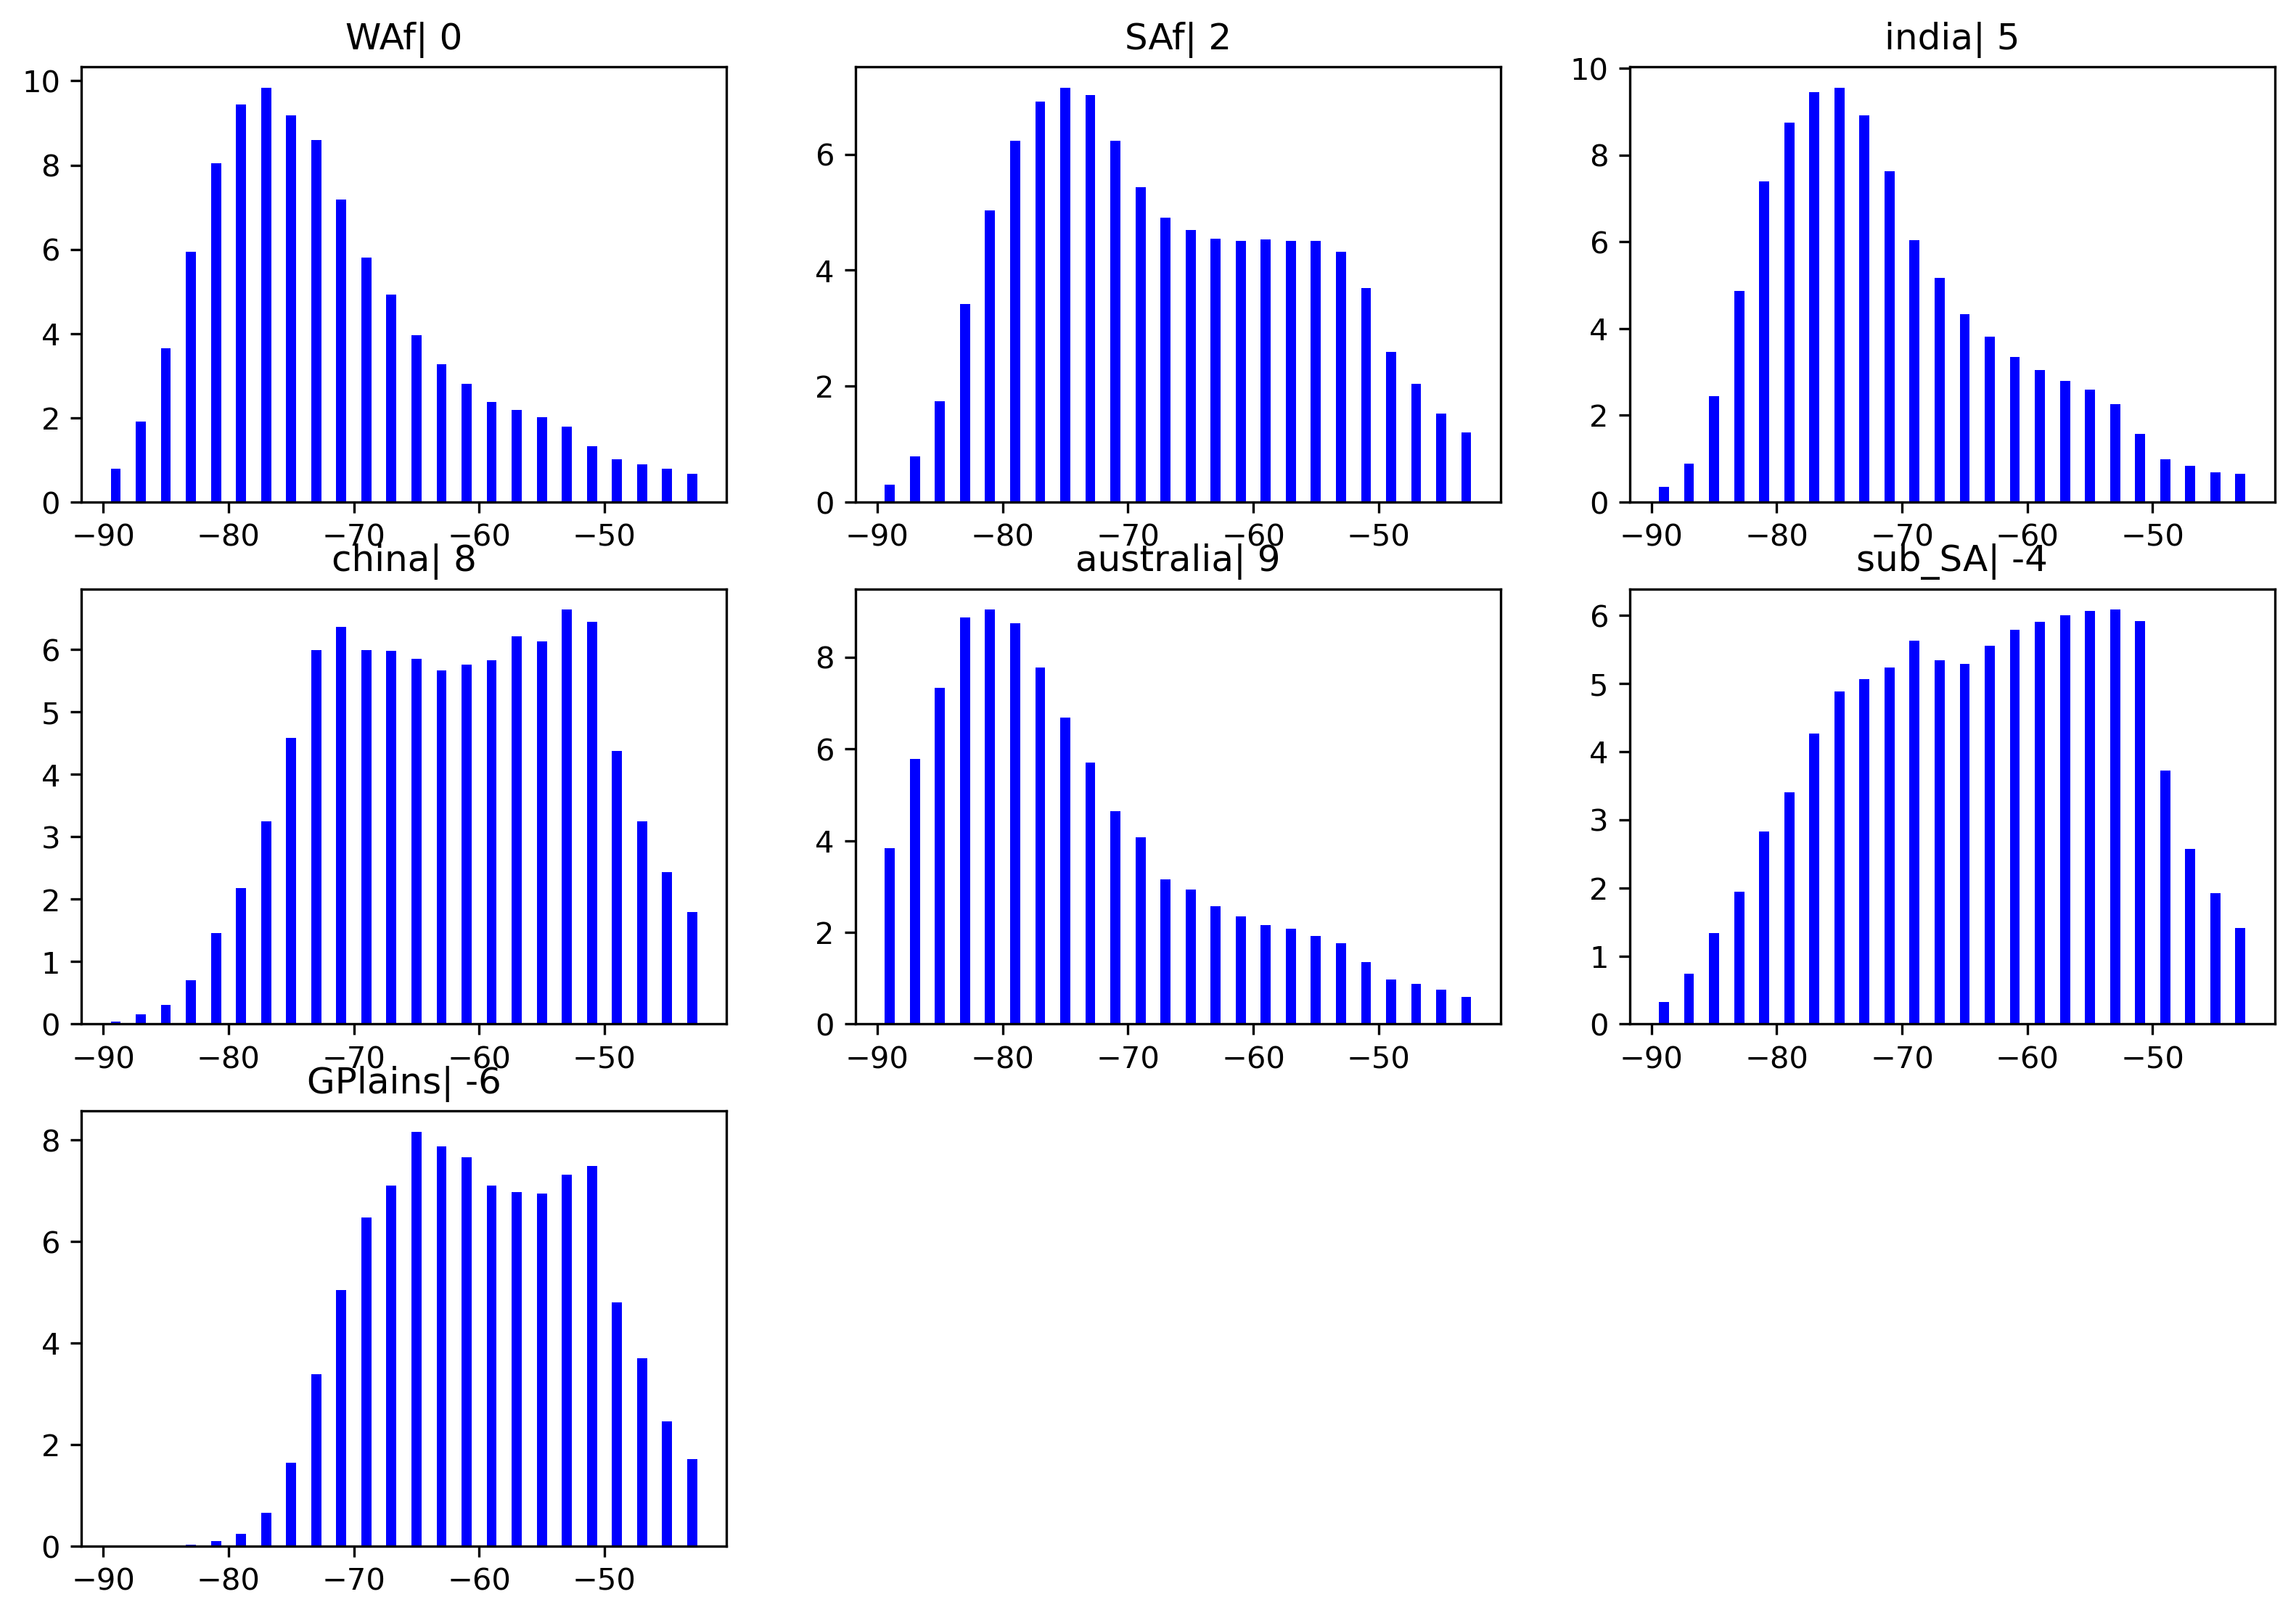

In [138]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    hist_freq, hist_count, bin_edge = u_stats.histo_frequency(pick['mintb']-273.15, bins=np.arange(-90,-40,2))
    #print(np.unique(pick['hour']))
    mid_bin = bin_edge[0:-1] + (bin_edge[1::]-bin_edge[0:-1])/2
    #m_bin = mid_bin - (MREGIONS[regs])[2]
    #print(mid_bin)
    colors = ['b']*24
#     ispos = int(np.where(mid_bin==18.5)[0])
#     secpos = int(np.where(mid_bin==13.5)[0])
#     firstpos = int(np.where(mid_bin==10.5)[0])
#     #minpos = ispos-(MREGIONS[regs])[2]
#     #ipdb.set_trace()
#     minpos = ispos-(MREGIONS[regs])[2]
#     miinpos = firstpos - (MREGIONS[regs])[2]
#     miiinpos = secpos - (MREGIONS[regs])[2]
#     print(minpos)
#     if minpos == 24:
#         minpos=0
    
#     colors[minpos] = 'r'
#     colors[miinpos] = 'turquoise'
#     colors[miiinpos] = 'purple'
    ax.bar(mid_bin,hist_freq, align='center', color=colors)
    ax.set_title(regs + '| '+str((MREGIONS[regs])[2]))
#f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_storm_mint_dist.jpg')

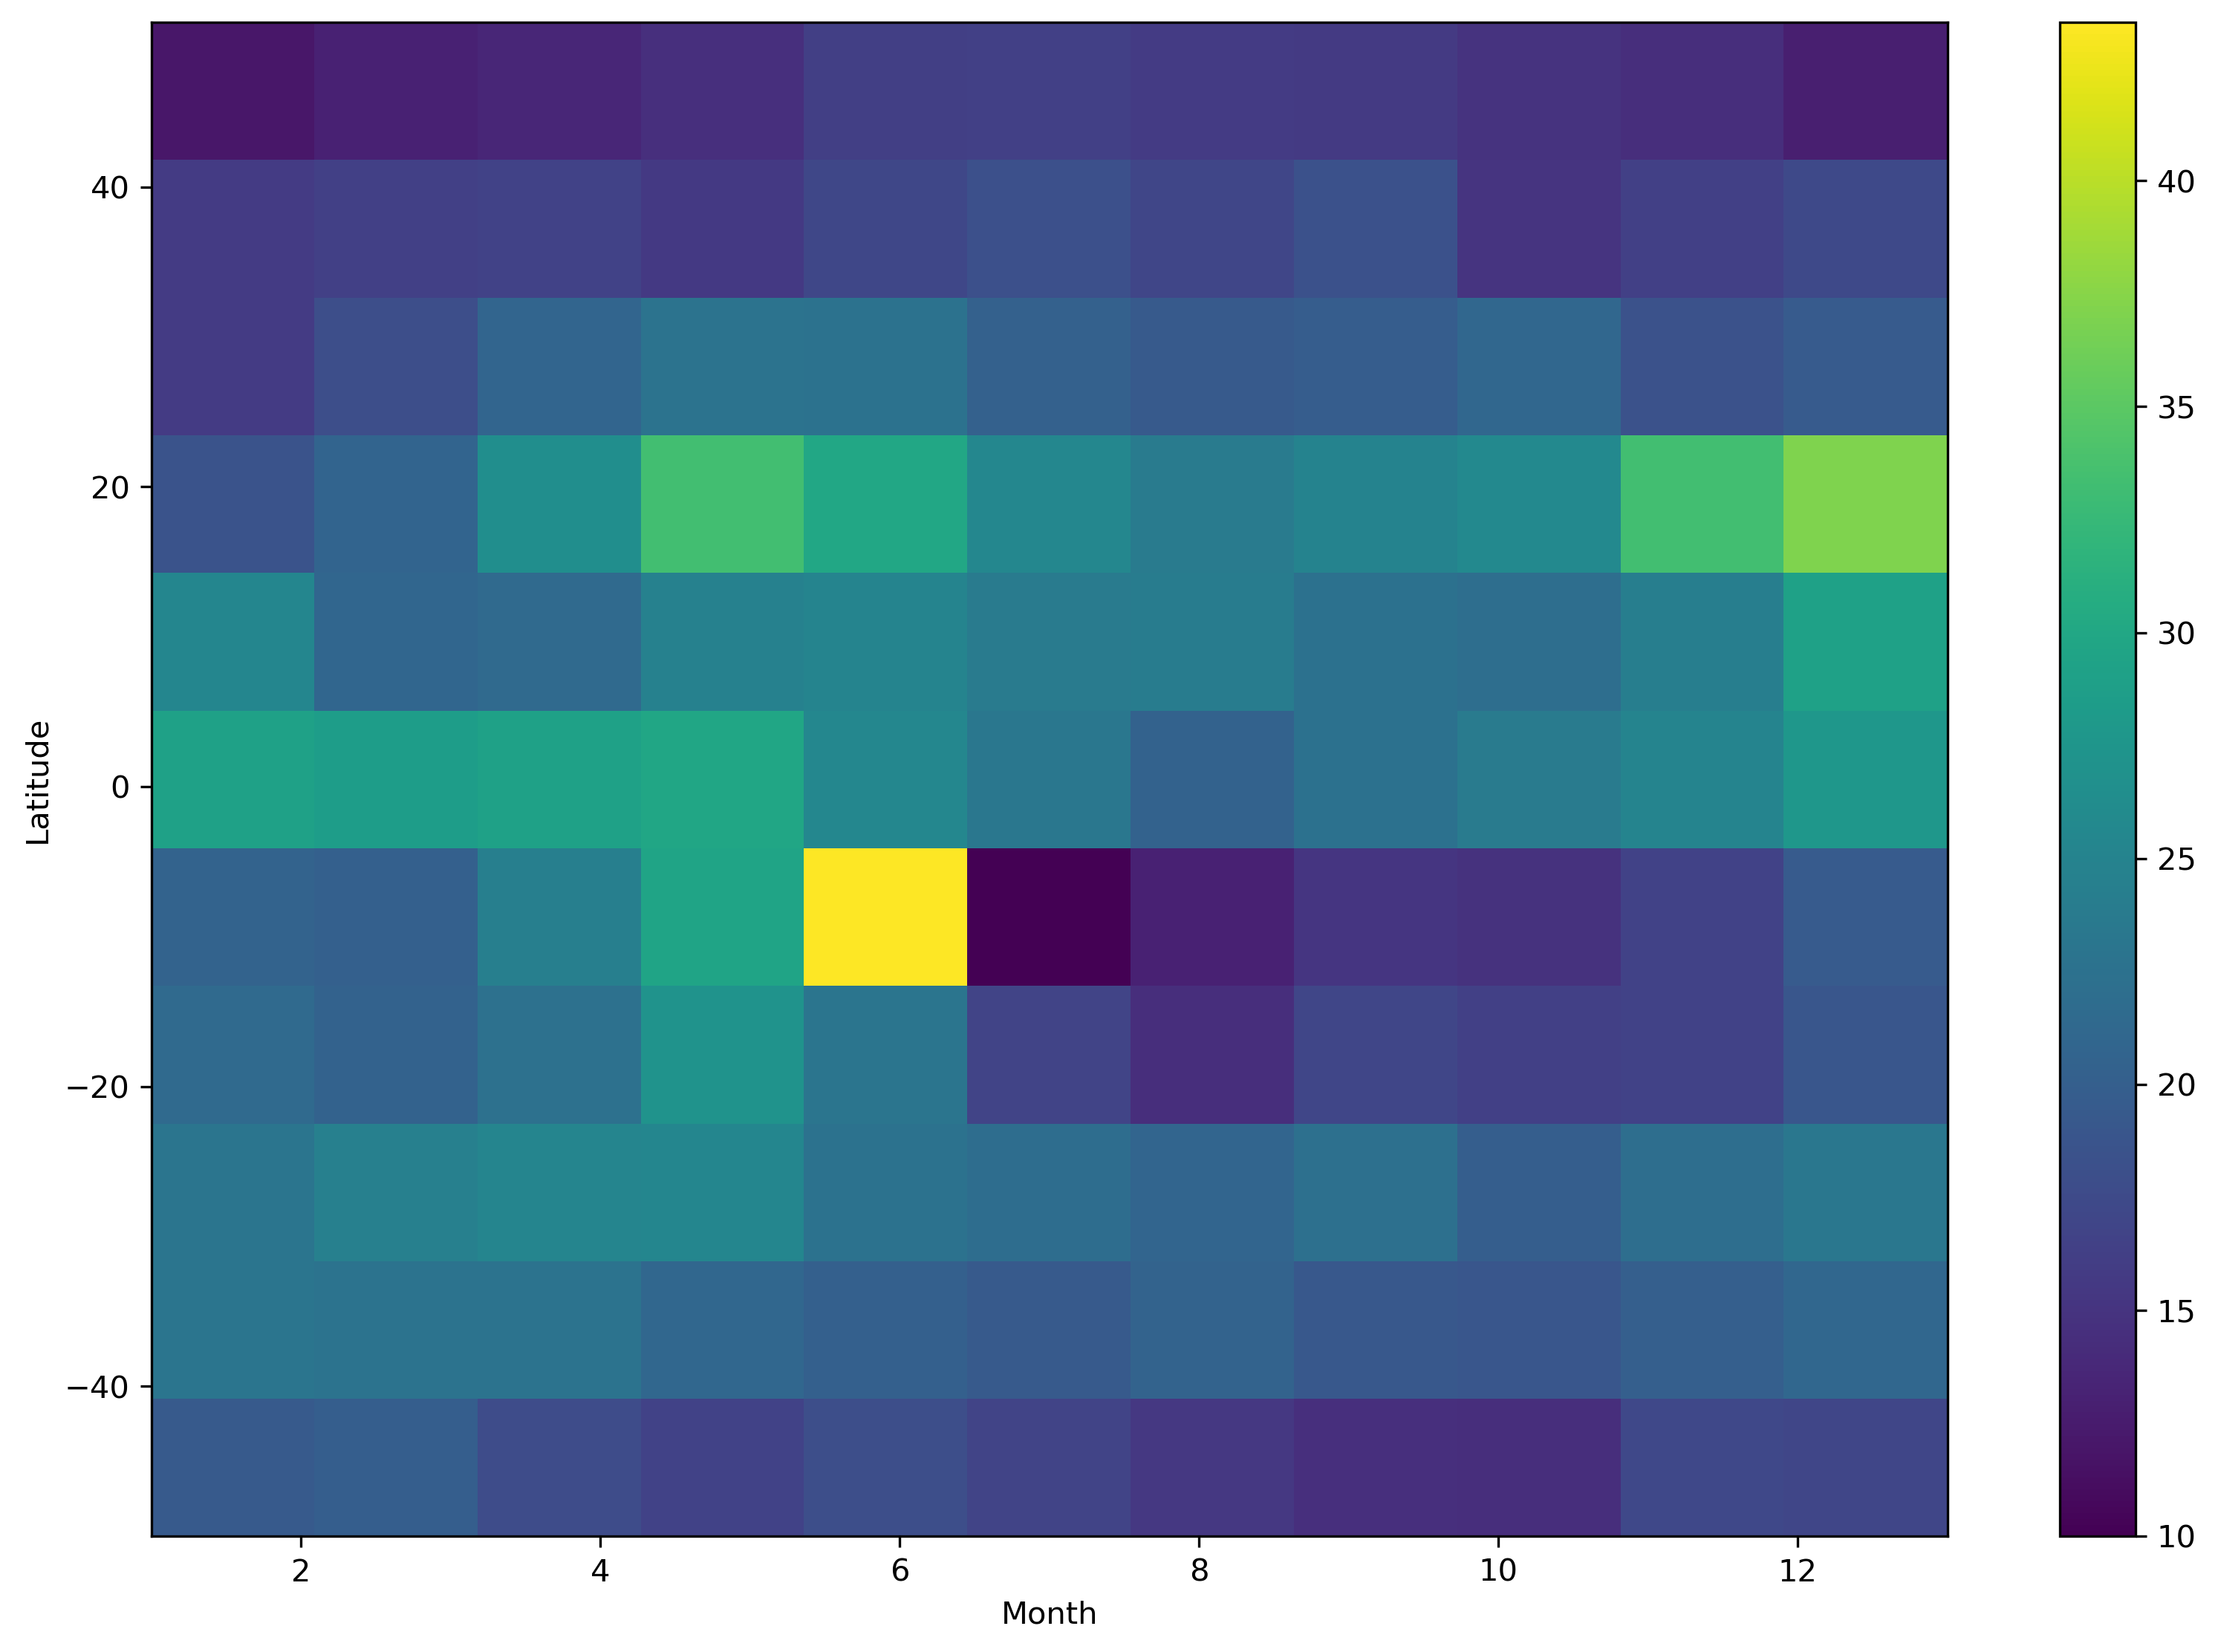

In [31]:
f= plt.figure(figsize=(13,9), dpi=300)
mon = []
lat = []
dat = []
for ids, regs in enumerate(MREGIONS.keys()):
    
    pick = rdics[regs]

    mon.extend(pick['month'])
    lat.extend(pick['meanlat'])
    dat.extend(pick['pf_maxrainrate1'])
    
    
tbin = np.linspace(-50,51,12)
sbin = np.linspace(1,13,12)

testbins = [sbin,tbin]
func1 = lambda y: np.nanmean(y) #np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
func2 = lambda y: np.nansum(np.isfinite(y))
func3 = lambda y: np.nansum(y>1)

ax = f.add_subplot(111)

ret = binned_statistic_2d(mon, lat, dat, statistic=func1, bins=testbins)
# count = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func2, bins=testbins)
# thresh = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func3, bins=testbins)

dd=ret.statistic.T

mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap='viridis', vmin=10) #vmax=p2-1, vmin=0.5  ##p2-1
plt.colorbar(mp)
plt.ylabel('Latitude')
plt.xlabel('Month')

# colours = ['r', 'k', 'b', 'y', 'g', 'w', 'r']
# for ids, regs in enumerate(MREGIONS.keys()):
    
#     pick = rdics[regs]
#     plt.scatter(pick['month'],pick['meanlat'], marker='x', s=1, color=colours[ids], label=regs)
# plt.legend(loc='upper left')
f.savefig('/home/ck/Desktop/lmcs/latitude_mean_pf1MaxRainrate_heatmap_mixed.jpg')

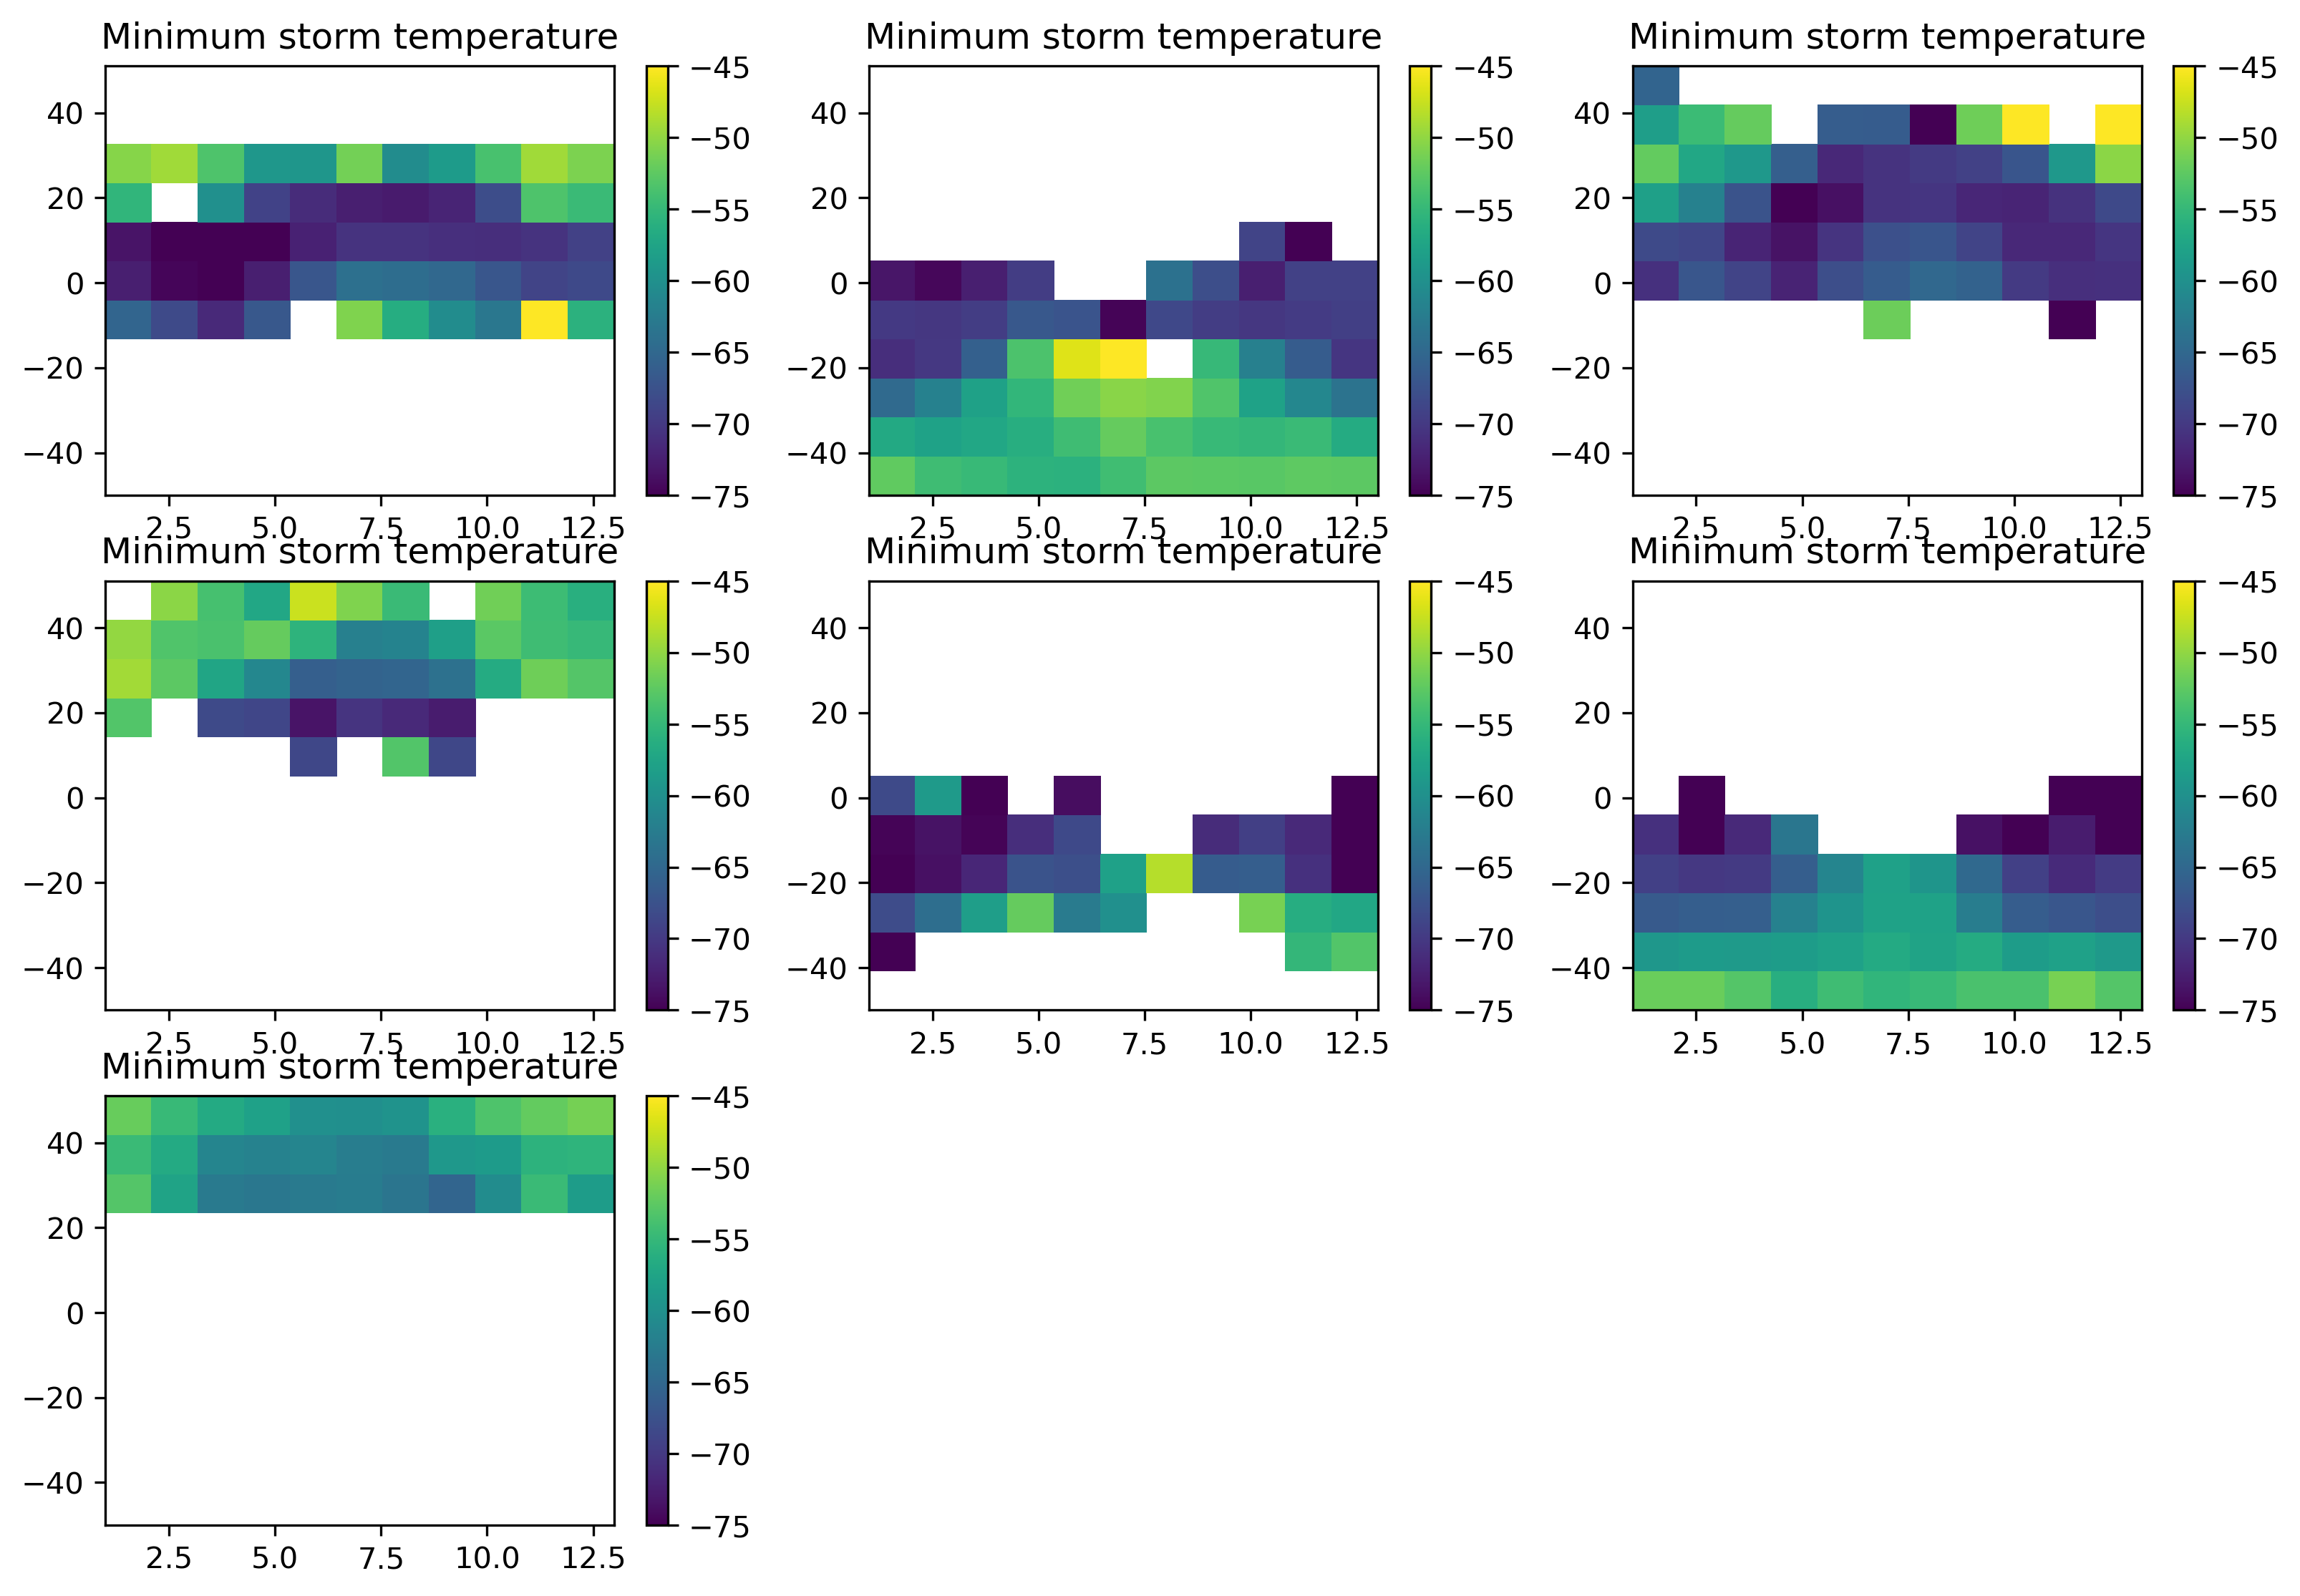

In [26]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    tbin = np.linspace(-50,51,12)
    sbin = np.linspace(1,13,12)

    testbins = [sbin,tbin]
    func1 = lambda y: np.mean(y) #np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
    func2 = lambda y: np.sum(np.isfinite(y))
    func3 = lambda y: np.sum(y>1)

    xxu2 = pick['month']
    xxtc = pick['meanlat']
    xxch = pick['mintb']-273.15
    
    ret = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func1, bins=testbins)
    # count = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func2, bins=testbins)
    # thresh = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func3, bins=testbins)

    dd=ret.statistic.T

    mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap='viridis', vmin=-75, vmax=-45) #vmax=p2-1, vmin=0.5  ##p2-1
    plt.title(regs+' IQR ='+str(np.round(np.nanpercentile(xxch,75)-np.nanpercentile(xxch,25),2))+'K')
    plt.colorbar(mp)
    plt.title('Minimum storm temperature')
f.savefig('/home/ck/Desktop/lmcs/latitude_mean_minT_heatmap_regions.jpg')

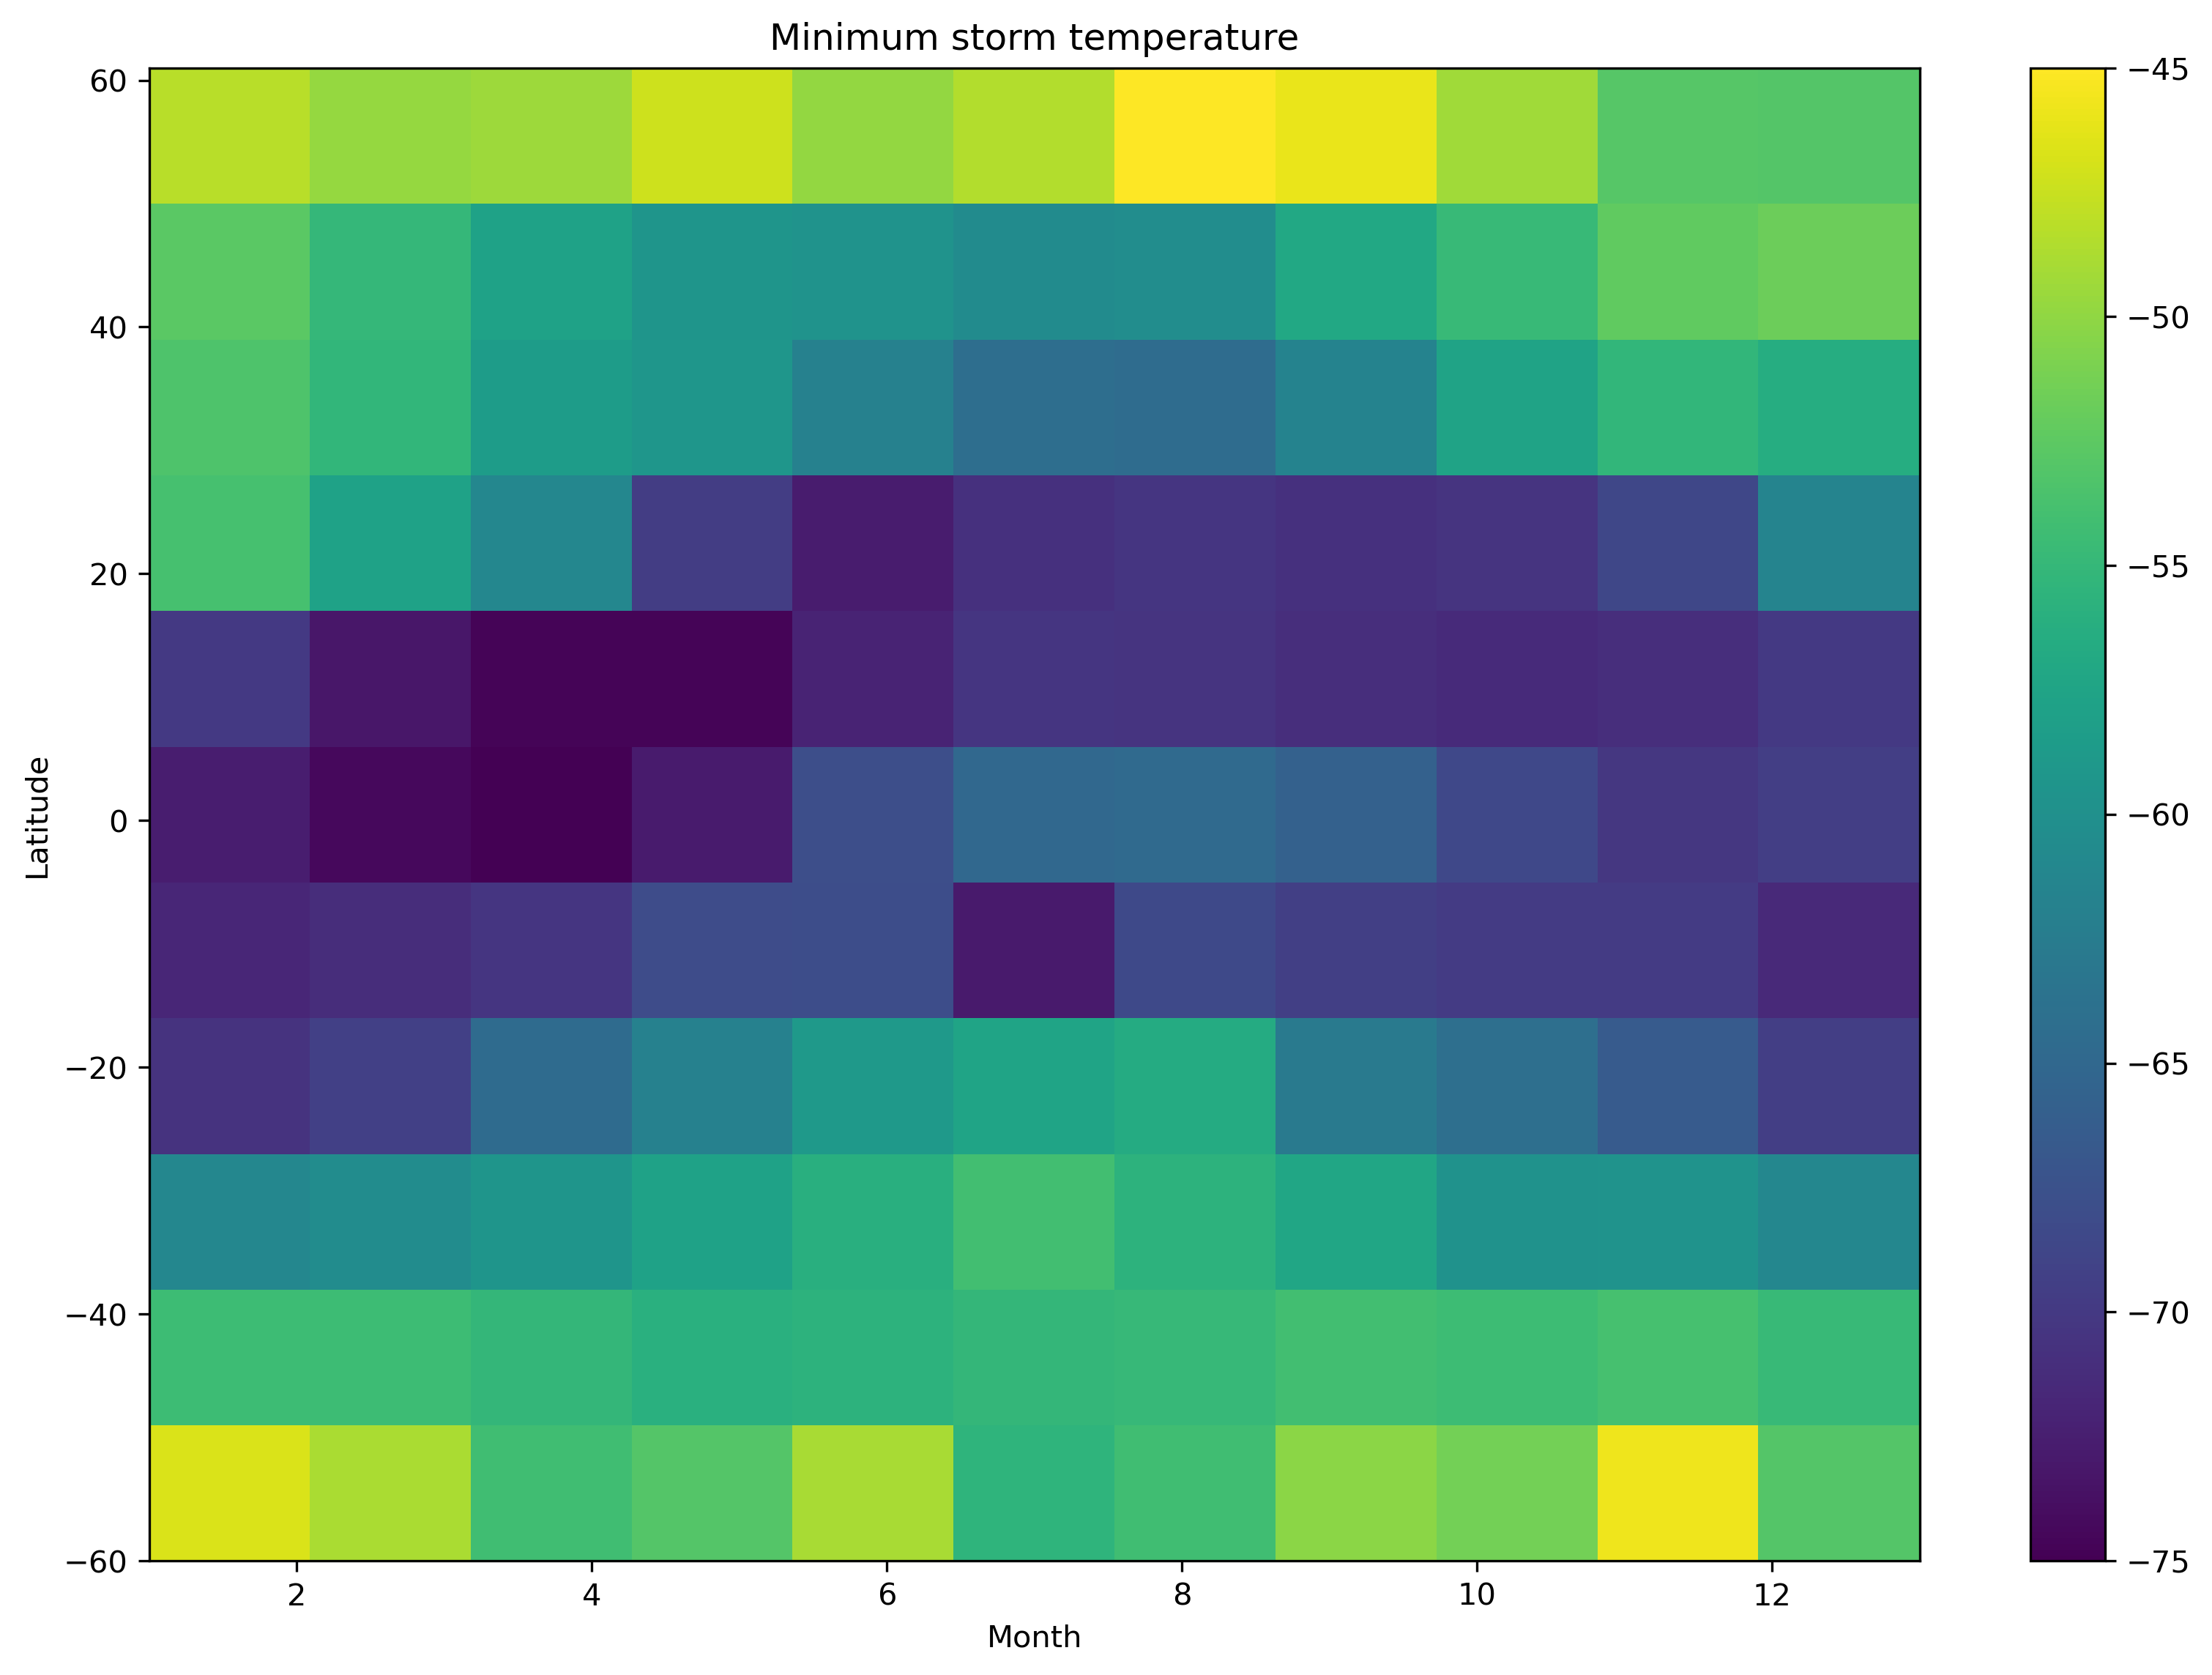

In [25]:
f= plt.figure(figsize=(13,9), dpi=300)
mon = []
lat = []
dat = []
for ids, regs in enumerate(MREGIONS.keys()):
    
    pick = rdics[regs]

    mon.extend(pick['month'])
    lat.extend(pick['meanlat'])
    dat.extend(pick['mintb']-273.15)
    
    
tbin = np.linspace(-60,61,12)
sbin = np.linspace(1,13,12)

testbins = [sbin,tbin]
func1 = lambda y: np.mean(y) #np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
func2 = lambda y: np.sum(np.isfinite(y))
func3 = lambda y: np.sum(y>1)

ax = f.add_subplot(111)

ret = binned_statistic_2d(mon, lat, dat, statistic=func1, bins=testbins)
# count = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func2, bins=testbins)
# thresh = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func3, bins=testbins)

dd=ret.statistic.T

mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap='viridis', vmin=-75, vmax=-45) #vmax=p2-1, vmin=0.5  ##p2-1
plt.colorbar(mp)
plt.ylabel('Latitude')
plt.xlabel('Month')
plt.title('Minimum storm temperature')

# colours = ['r', 'k', 'b', 'y', 'g', 'w', 'r']
# for ids, regs in enumerate(MREGIONS.keys()):
    
#     pick = rdics[regs]
#     plt.scatter(pick['month'],pick['meanlat'], marker='x', s=1, color=colours[ids], label=regs)
# plt.legend(loc='upper left')
f.savefig('/home/ck/Desktop/lmcs/latitude_mean_minT_heatmap_mixed.jpg')

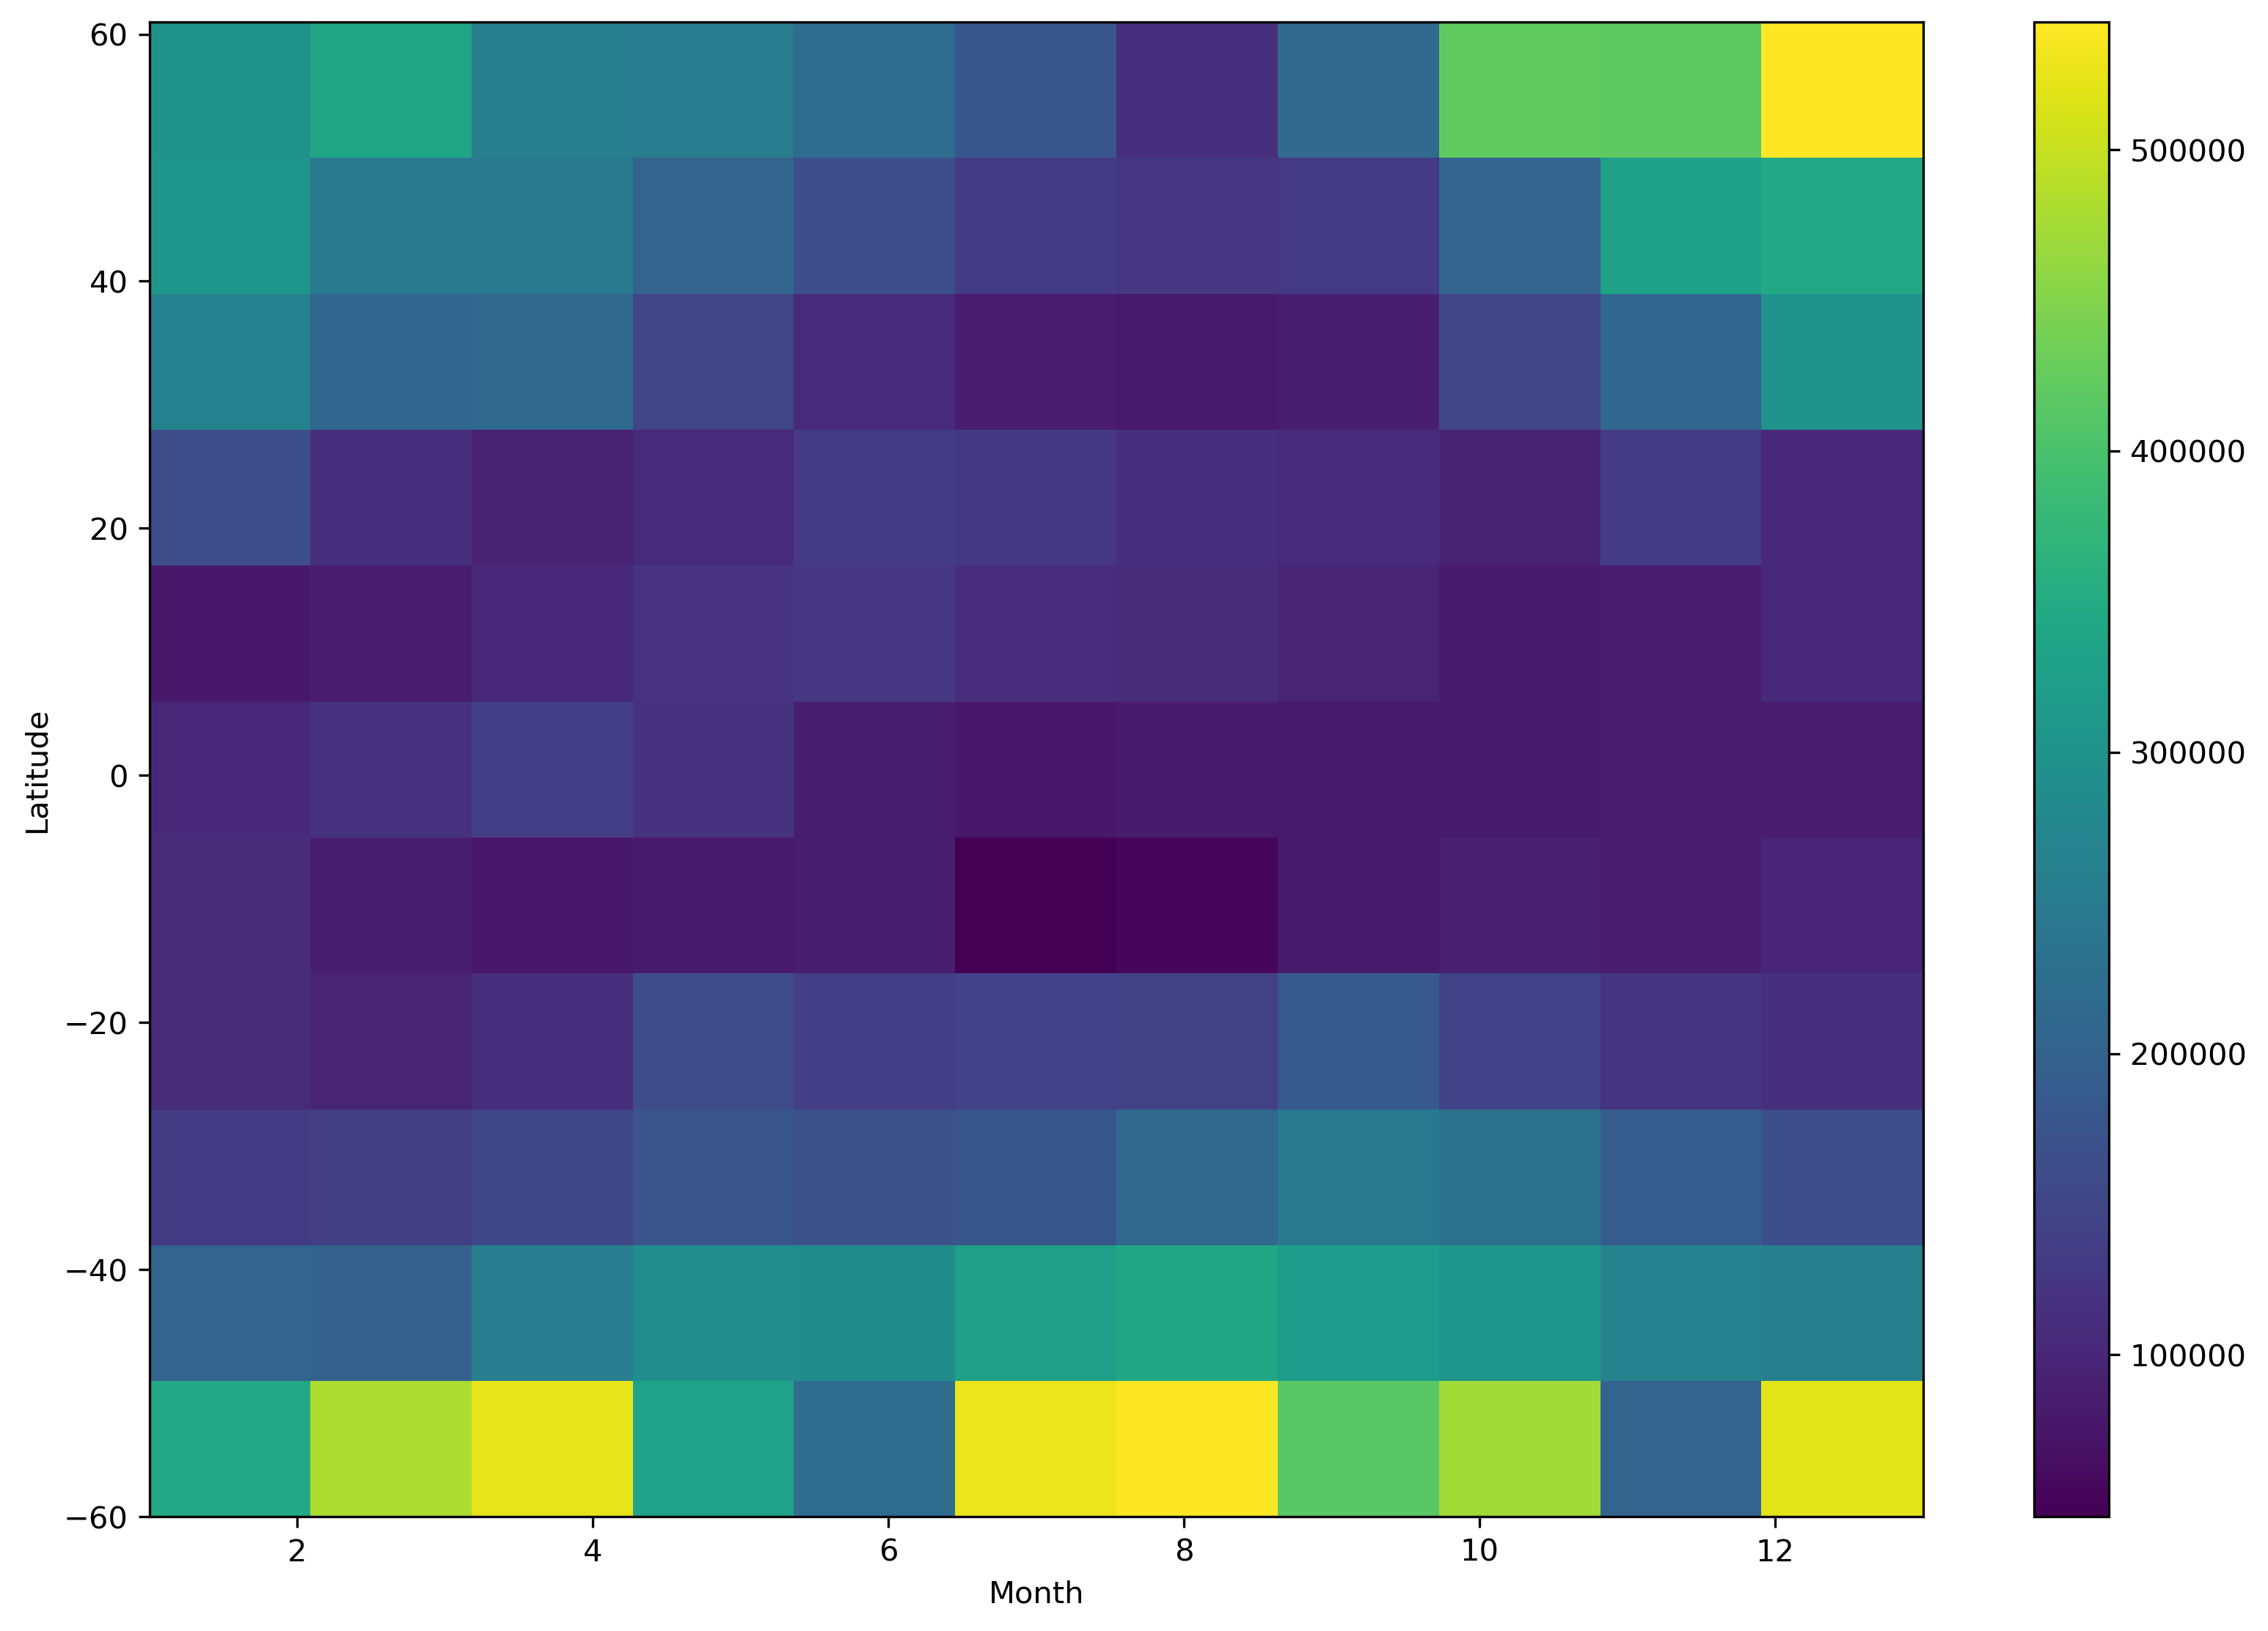

In [22]:
f= plt.figure(figsize=(13,9), dpi=300)
mon = []
lat = []
dat = []
for ids, regs in enumerate(MREGIONS.keys()):
    
    pick = rdics[regs]

    mon.extend(pick['month'])
    lat.extend(pick['meanlat'])
    dat.extend(pick['ccs_area'])
    
    
tbin = np.linspace(-60,61,12)
sbin = np.linspace(1,13,12)

testbins = [sbin,tbin]
func1 = lambda y: np.mean(y) #np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
func2 = lambda y: np.sum(np.isfinite(y))
func3 = lambda y: np.sum(y>1)

ax = f.add_subplot(111)

ret = binned_statistic_2d(mon, lat, dat, statistic=func1, bins=testbins)
# count = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func2, bins=testbins)
# thresh = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func3, bins=testbins)

dd=ret.statistic.T

mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap='viridis') #vmax=p2-1, vmin=0.5  ##p2-1
plt.colorbar(mp)
plt.ylabel('Latitude')
plt.xlabel('Month')

# colours = ['r', 'k', 'b', 'y', 'g', 'w', 'r']
# for ids, regs in enumerate(MREGIONS.keys()):
    
#     pick = rdics[regs]
#     plt.scatter(pick['month'],pick['meanlat'], marker='x', s=1, color=colours[ids], label=regs)
# plt.legend(loc='upper left')
f.savefig('/home/ck/Desktop/lmcs/latitude_mean_minT_heatmap_ccsArea.jpg')

Text(0.5, 0, 'Month')

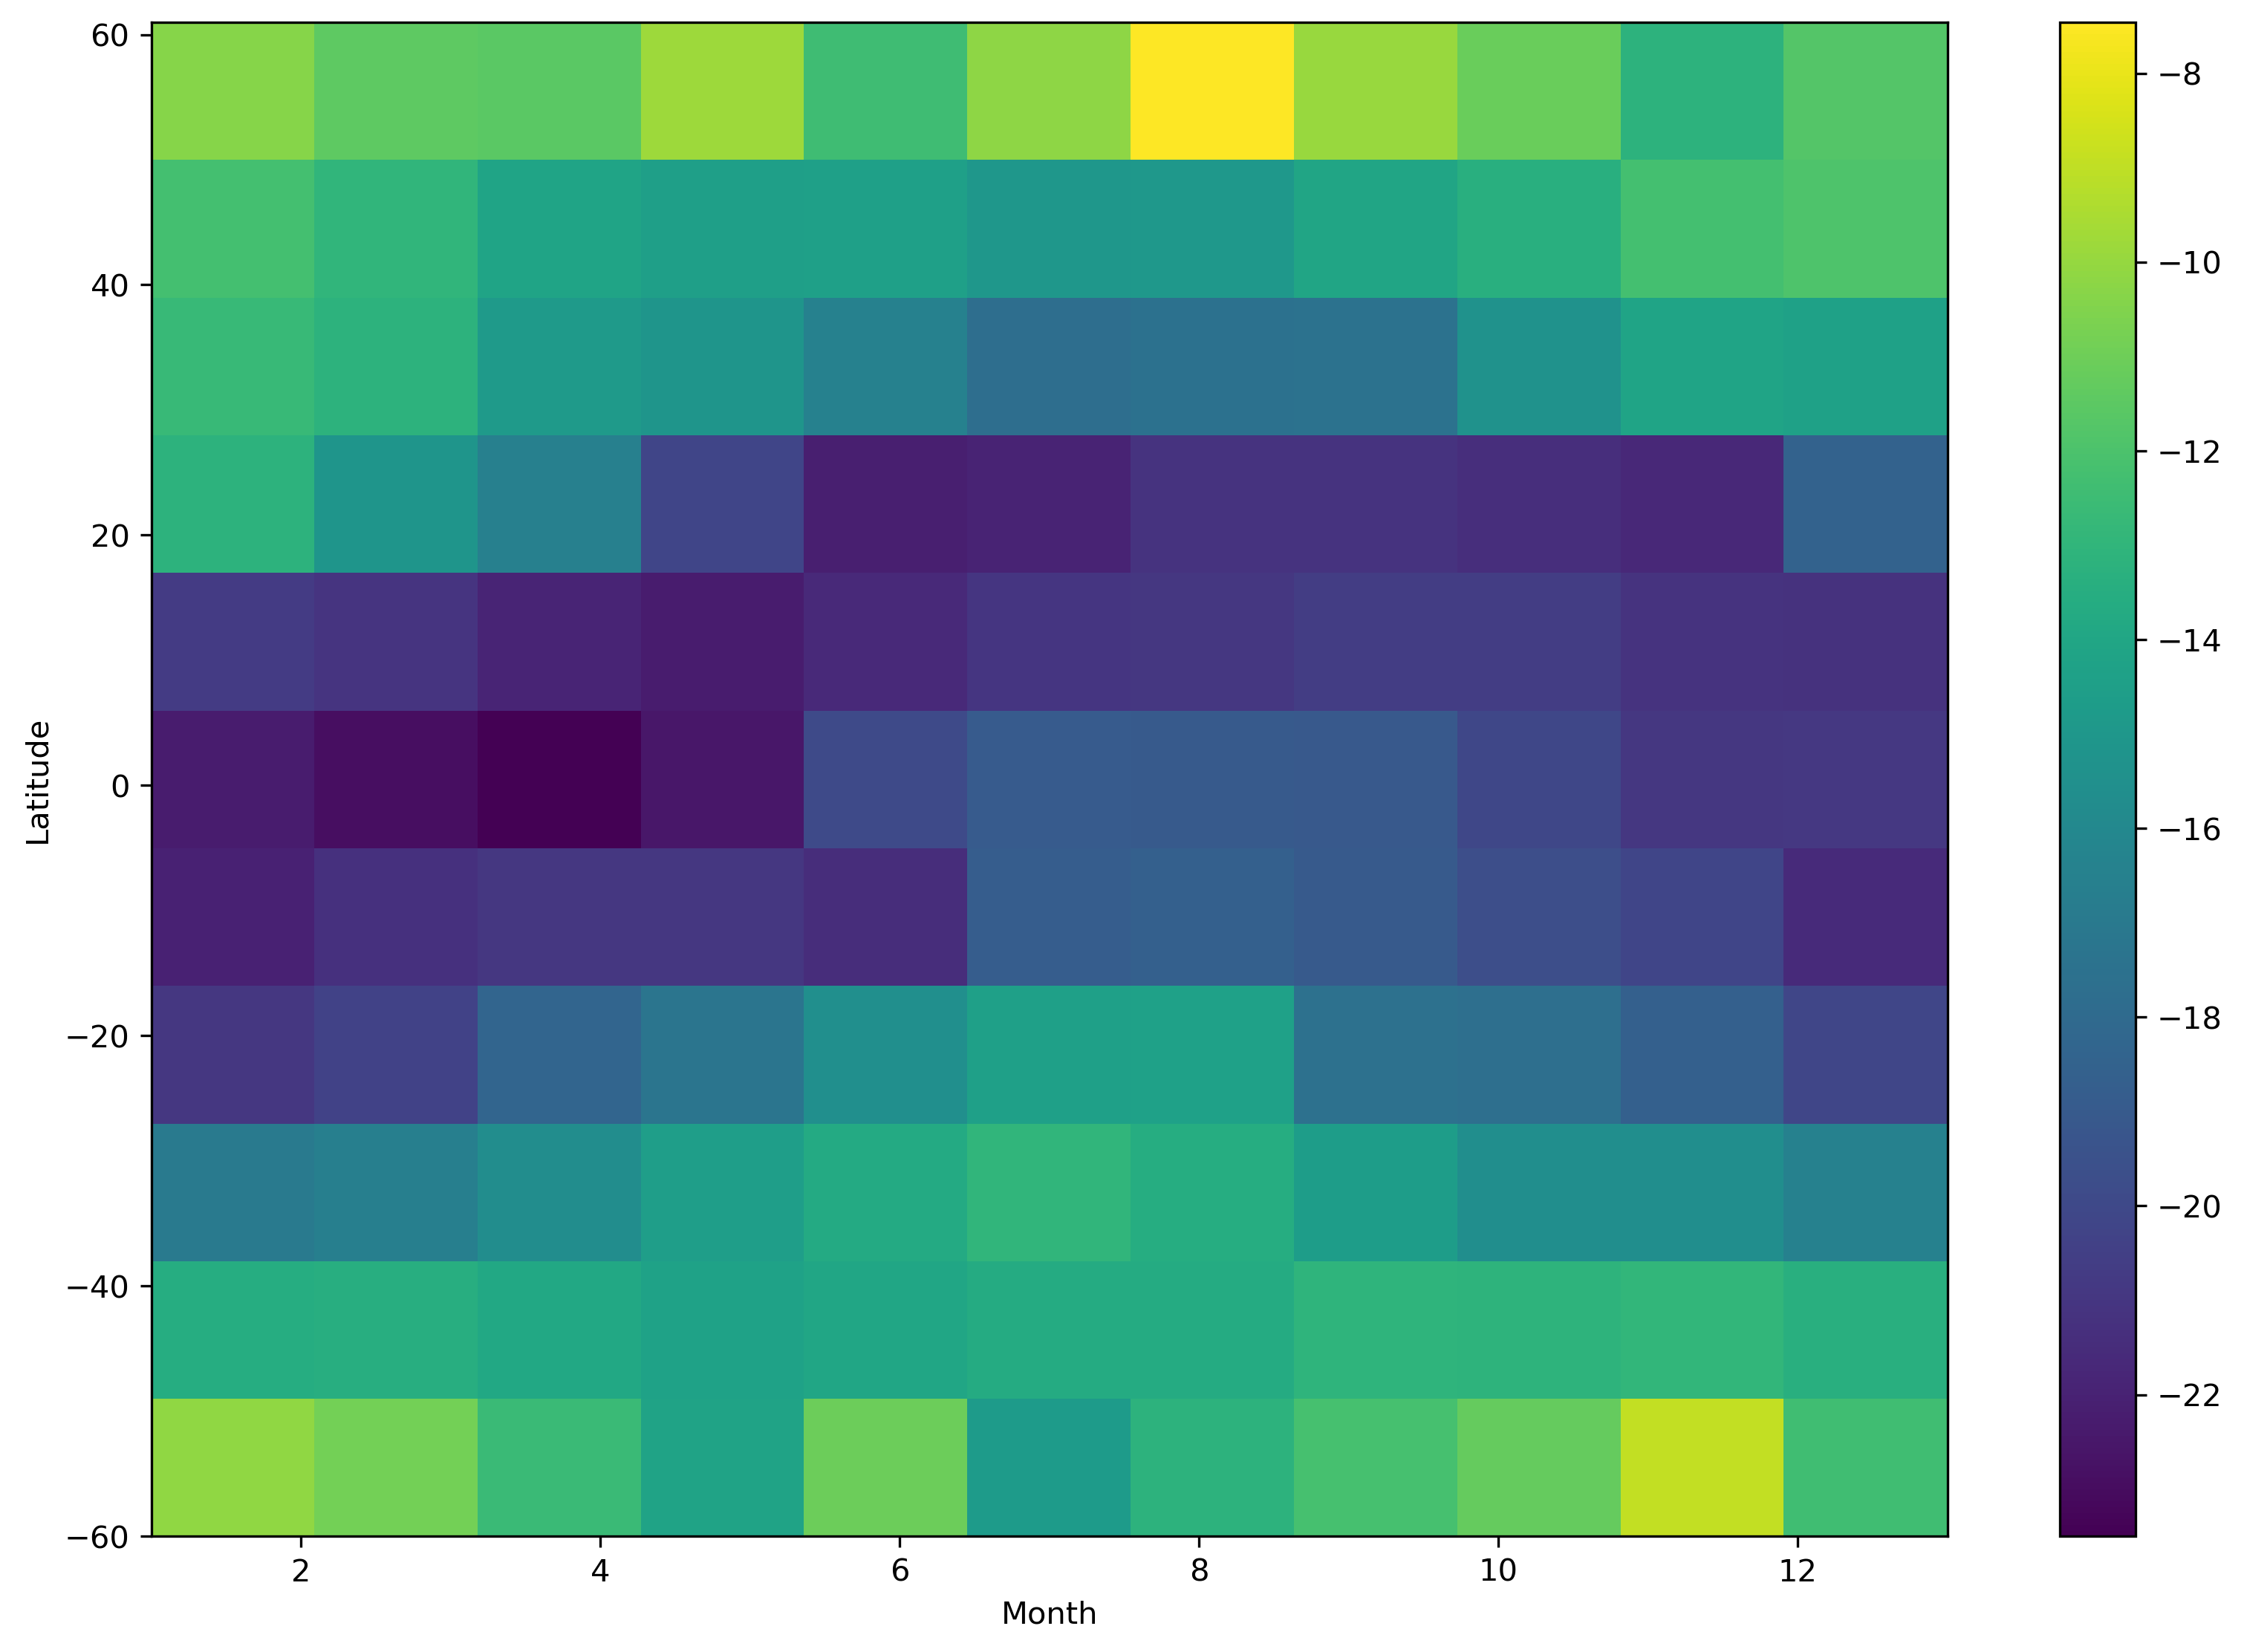

In [126]:
f= plt.figure(figsize=(13,9), dpi=300)
mon = []
lat = []
dat = []
for ids, regs in enumerate(MREGIONS.keys()):
    
    pick = rdics[regs]

    mon.extend(pick['month'])
    lat.extend(pick['meanlat'])
    dat.extend(pick['mintb']-pick['meantb'])
    
    
tbin = np.linspace(-60,61,12)
sbin = np.linspace(1,13,12)

testbins = [sbin,tbin]
func1 = lambda y: np.mean(y) #np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
func2 = lambda y: np.sum(np.isfinite(y))
func3 = lambda y: np.sum(y>1)

ax = f.add_subplot(111)

ret = binned_statistic_2d(mon, lat, dat, statistic=func1, bins=testbins)
# count = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func2, bins=testbins)
# thresh = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func3, bins=testbins)

dd=ret.statistic.T

mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap='viridis') #vmax=p2-1, vmin=0.5  ##p2-1
plt.colorbar(mp)
plt.ylabel('Latitude')
plt.xlabel('Month')

# colours = ['r', 'k', 'b', 'y', 'g', 'w', 'r']
# for ids, regs in enumerate(MREGIONS.keys()):
    
#     pick = rdics[regs]
#     plt.scatter(pick['month'],pick['meanlat'], marker='x', s=1, color=colours[ids], label=regs)
# plt.legend(loc='upper left')

Text(0.5, 0, 'Month')

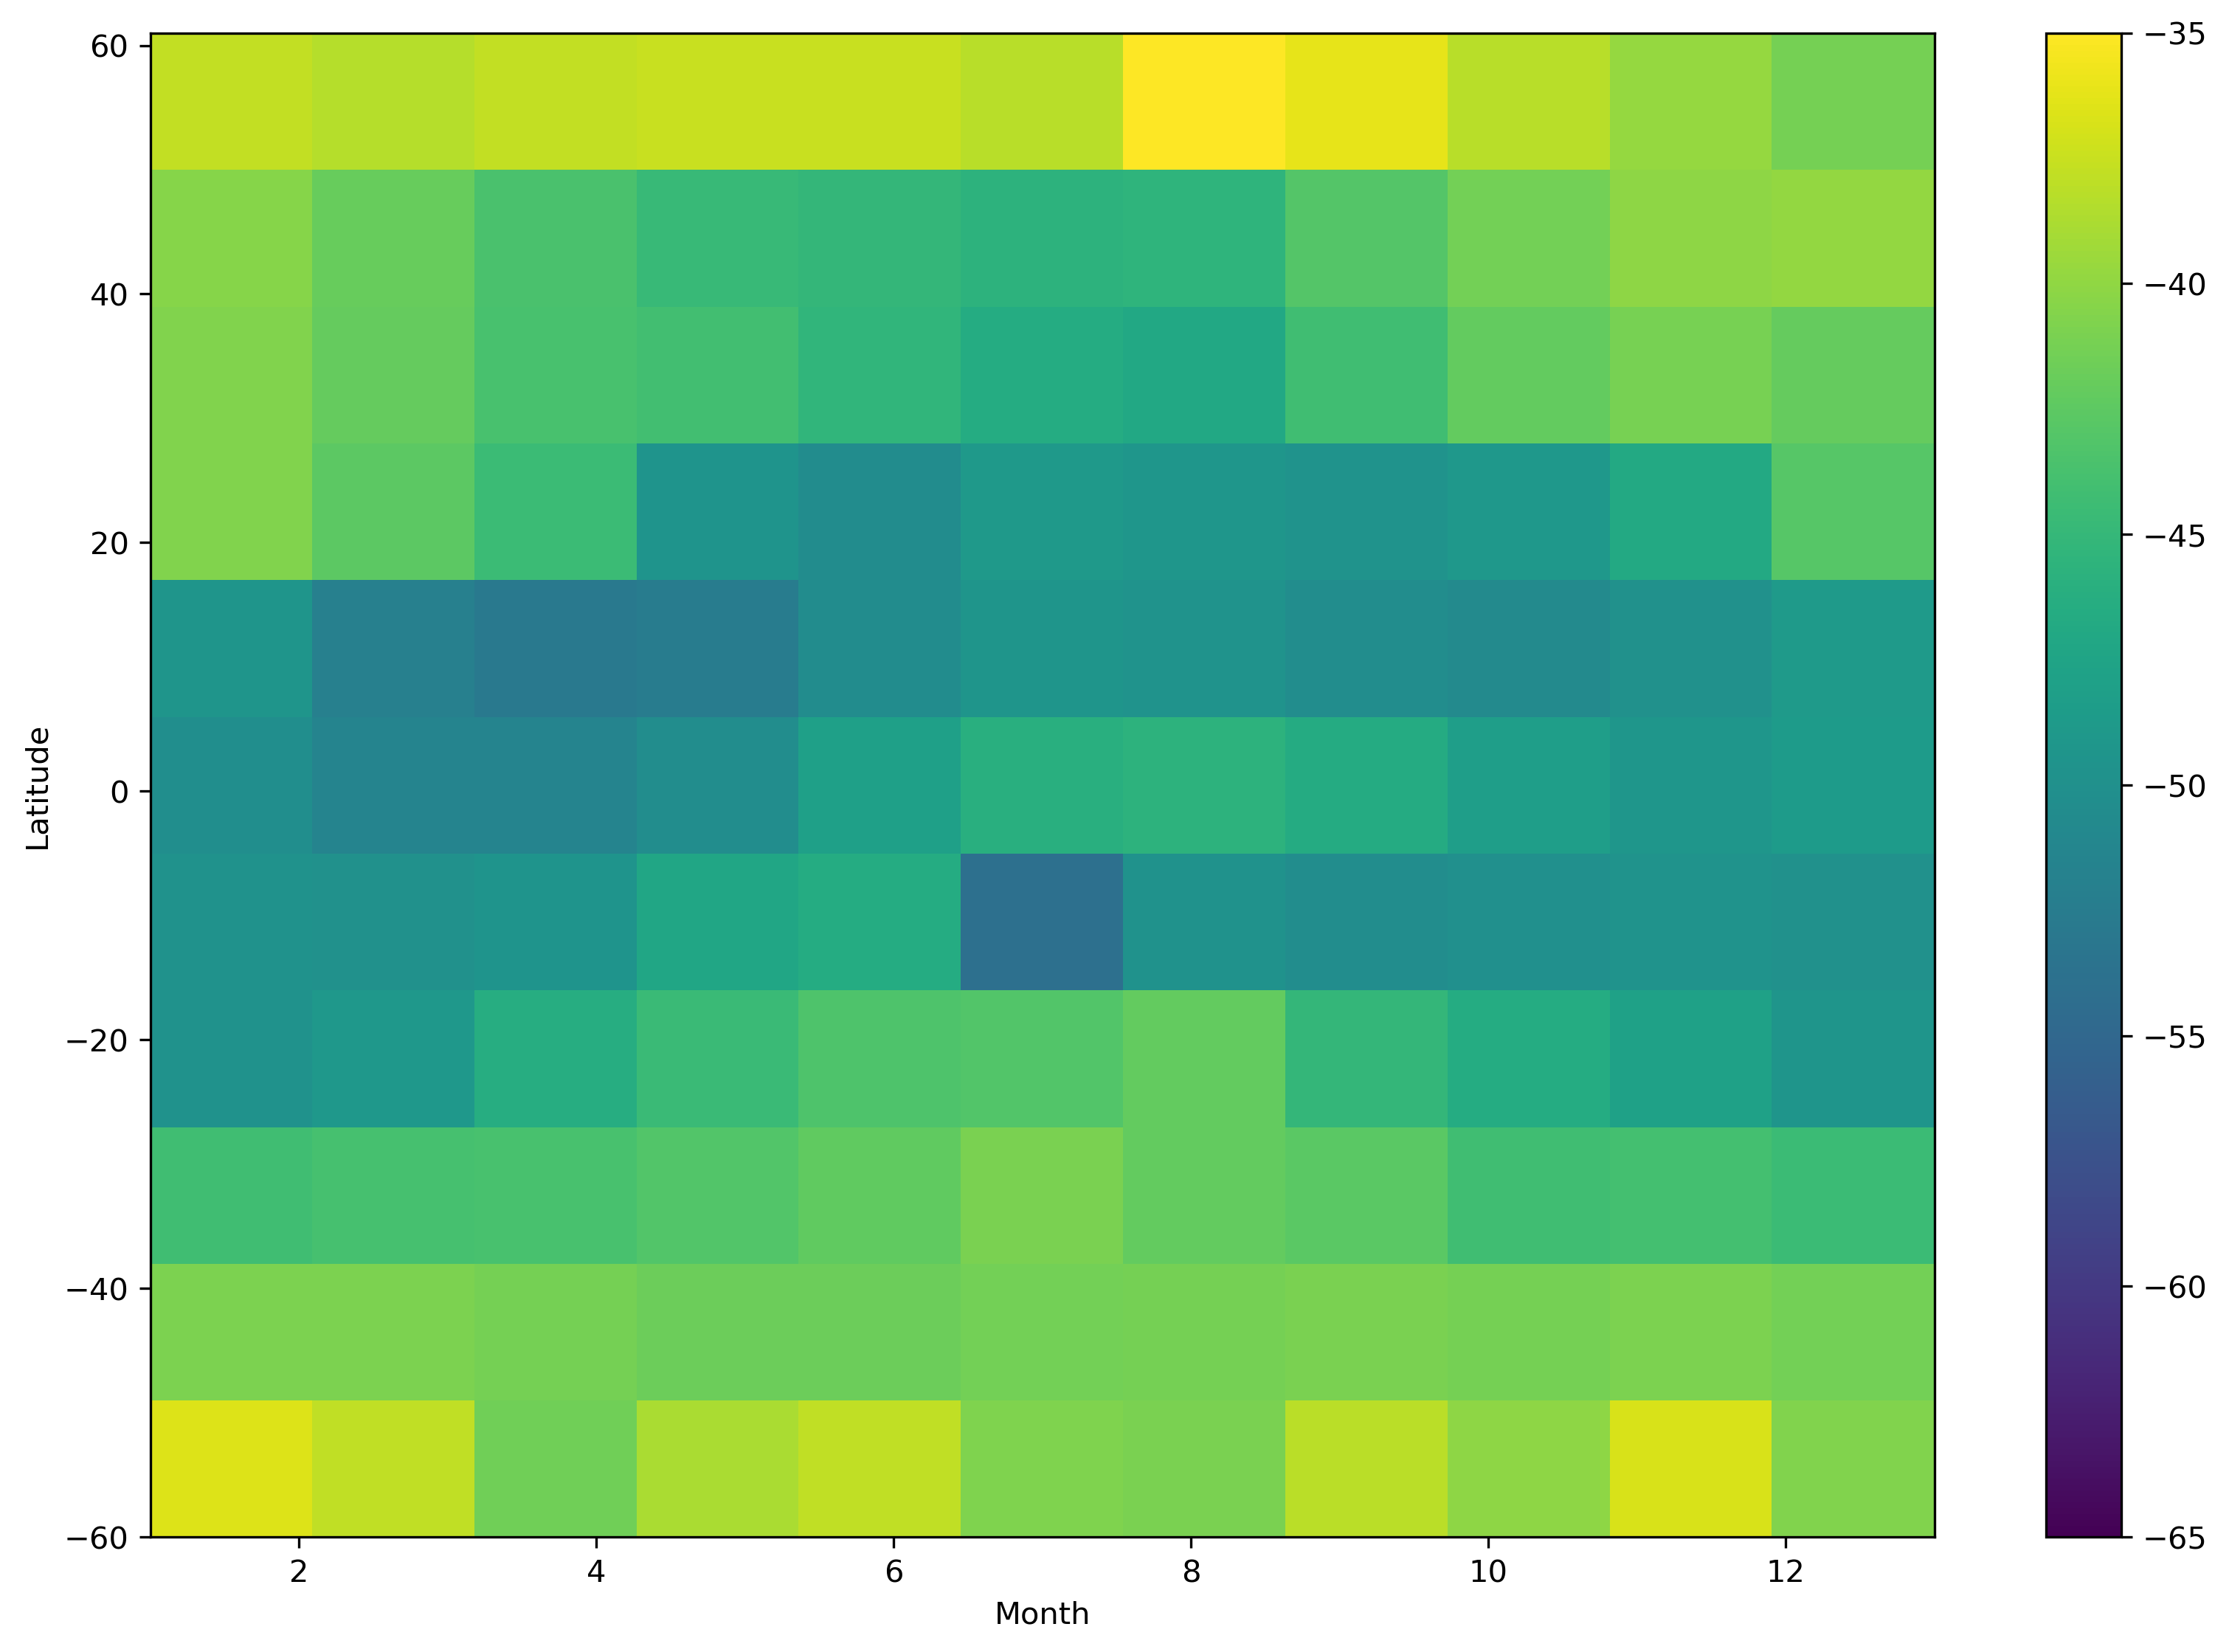

In [121]:
f= plt.figure(figsize=(13,9), dpi=300)
mon = []
lat = []
dat = []
for ids, regs in enumerate(MREGIONS.keys()):
    
    pick = rdics[regs]

    mon.extend(pick['month'])
    lat.extend(pick['meanlat'])
    dat.extend(pick['meantb']-273.15)
    
    
tbin = np.linspace(-60,61,12)
sbin = np.linspace(1,13,12)

testbins = [sbin,tbin]
func1 = lambda y: np.mean(y) #np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
func2 = lambda y: np.sum(np.isfinite(y))
func3 = lambda y: np.sum(y>1)

ax = f.add_subplot(111)

ret = binned_statistic_2d(mon, lat, dat, statistic=func1, bins=testbins)
# count = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func2, bins=testbins)
# thresh = binned_statistic_2d(xxu2, xxtc, xxch, statistic=func3, bins=testbins)

dd=ret.statistic.T

mp = plt.pcolormesh(testbins[0], testbins[1], dd, cmap='viridis', vmin=-65, vmax=-35) #vmax=p2-1, vmin=0.5  ##p2-1
plt.colorbar(mp)
plt.ylabel('Latitude')
plt.xlabel('Month')

# colours = ['r', 'k', 'b', 'y', 'g', 'w', 'r']
# for ids, regs in enumerate(MREGIONS.keys()):
    
#     pick = rdics[regs]
#     plt.scatter(pick['month'],pick['meanlat'], marker='x', s=1, color=colours[ids], label=regs)
# plt.legend(loc='upper left')

In [23]:
import windrose 
from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.projections import register_projection

register_projection(WindroseAxes)
color_s = ['red', 'blue', 'lime', 'yellow', 'violet', 'aqua', 'pink', 'grey', 'darkred', 'navy', 'green']

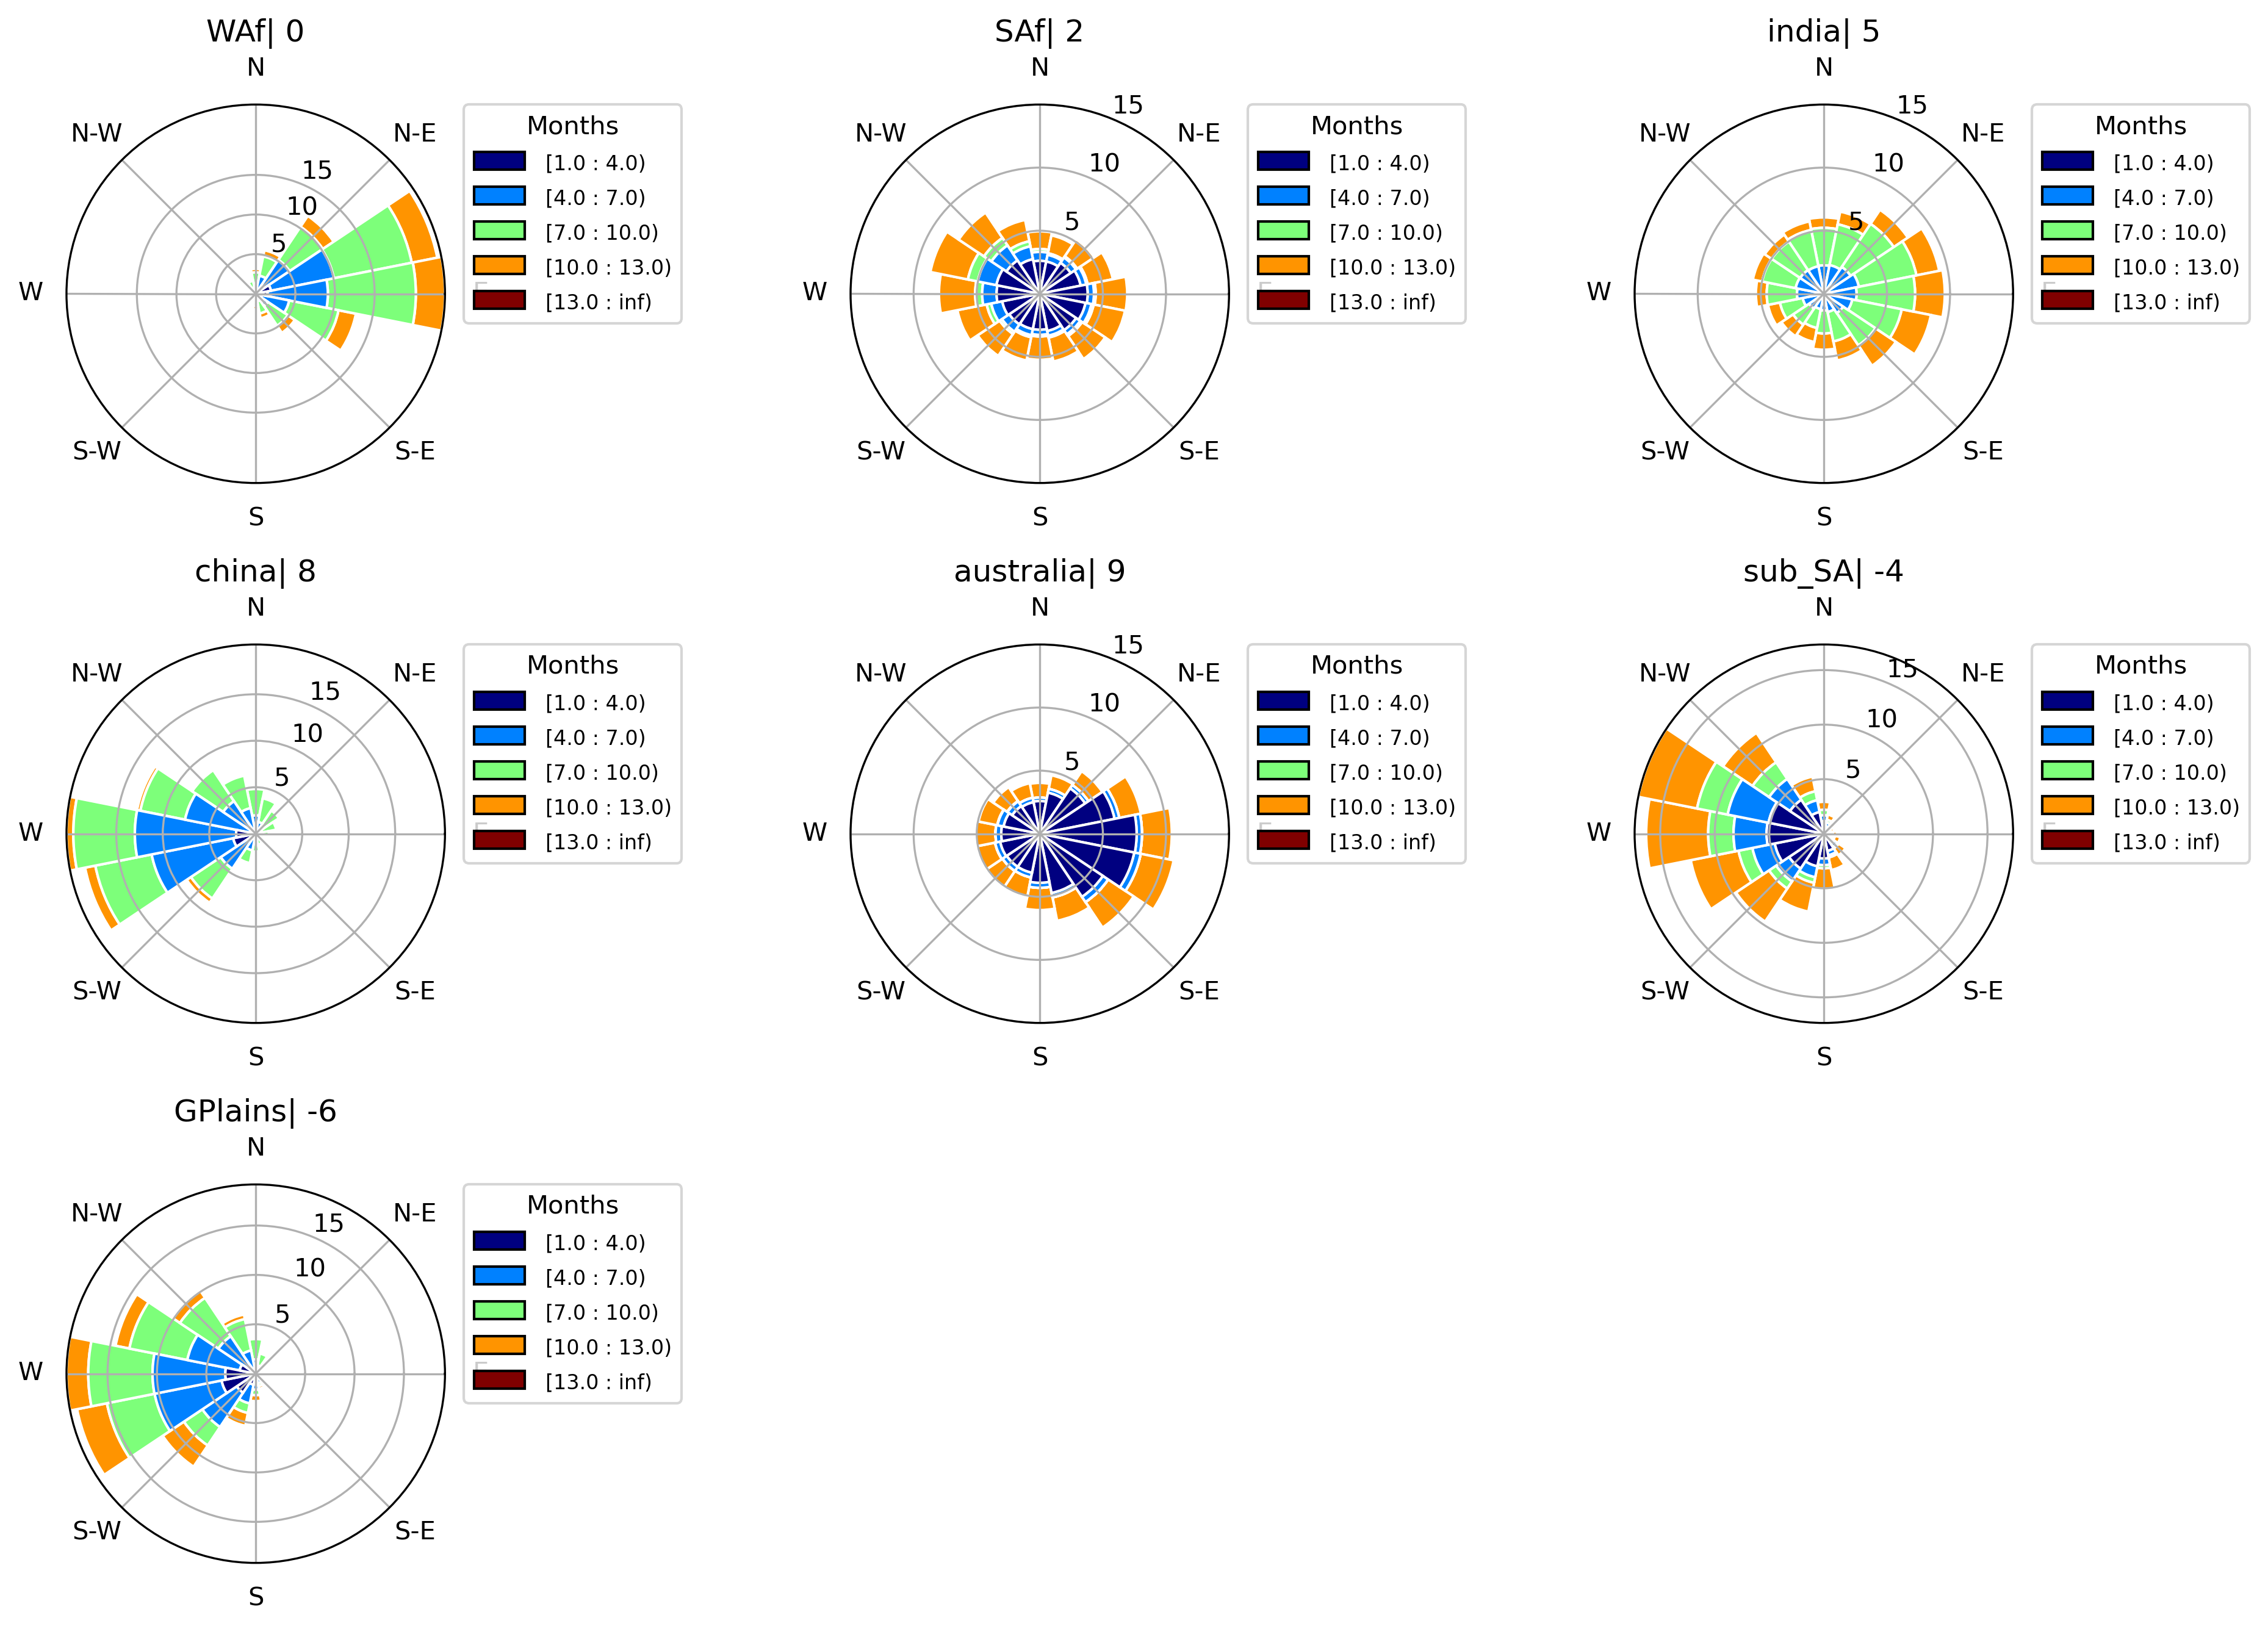

In [24]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1,  projection='windrose')
    
    pick = rdics[regs]

    umean = np.sin(np.deg2rad(pick['direction-1'])) + np.sin(np.deg2rad(pick['direction1'])) +  np.sin(np.deg2rad(pick['direction0'])) +  np.sin(np.deg2rad(pick['direction-2']))
    vmean = np.cos(np.deg2rad(pick['direction-1'])) + np.cos(np.deg2rad(pick['direction1'])) +  np.cos(np.deg2rad(pick['direction0'])) +  np.cos(np.deg2rad(pick['direction-2']))

    avg_wd = np.rad2deg(np.arctan2(umean, vmean))
    
    posi = np.where(avg_wd<0)
    #ipdb.set_trace()
    avg_wd  = avg_wd.values
    avg_wd[posi[0]] = avg_wd[posi[0]] + 360

    # print('mean WD', avg_wd, fi['d60irection'])
    direct = avg_wd -180
    direct[direct<0] = direct[direct<0] +360
    
   # direct = pick['direction0']0
    
    #####################
    ws_array2 = pick['month']  #np.array(wsin.flatten())
    wd_array2 = direct

    ax = WindroseAxes.from_ax(ax)
    ax.bar(wd_array2, ws_array2, normed=True, opening=1.0, edgecolor='white', bins=[1,4,7,10,13])
    ax.set_yticks(np.arange(5, 20, step=5))
    ax.set_yticklabels(np.arange(5, 20, step=5))



    ax.set_title(regs + '| '+str((MREGIONS[regs])[2]))
    ax.set_legend(title = 'Months', bbox_to_anchor=(1.05, 1), loc='upper left', handles = color_s, borderaxespad=0.)
#f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_storm_mint_dist.jpg')

plt.tight_layout()
f.savefig('/home/ck/Desktop/lmcs/storm_direction_windrose.jpg')

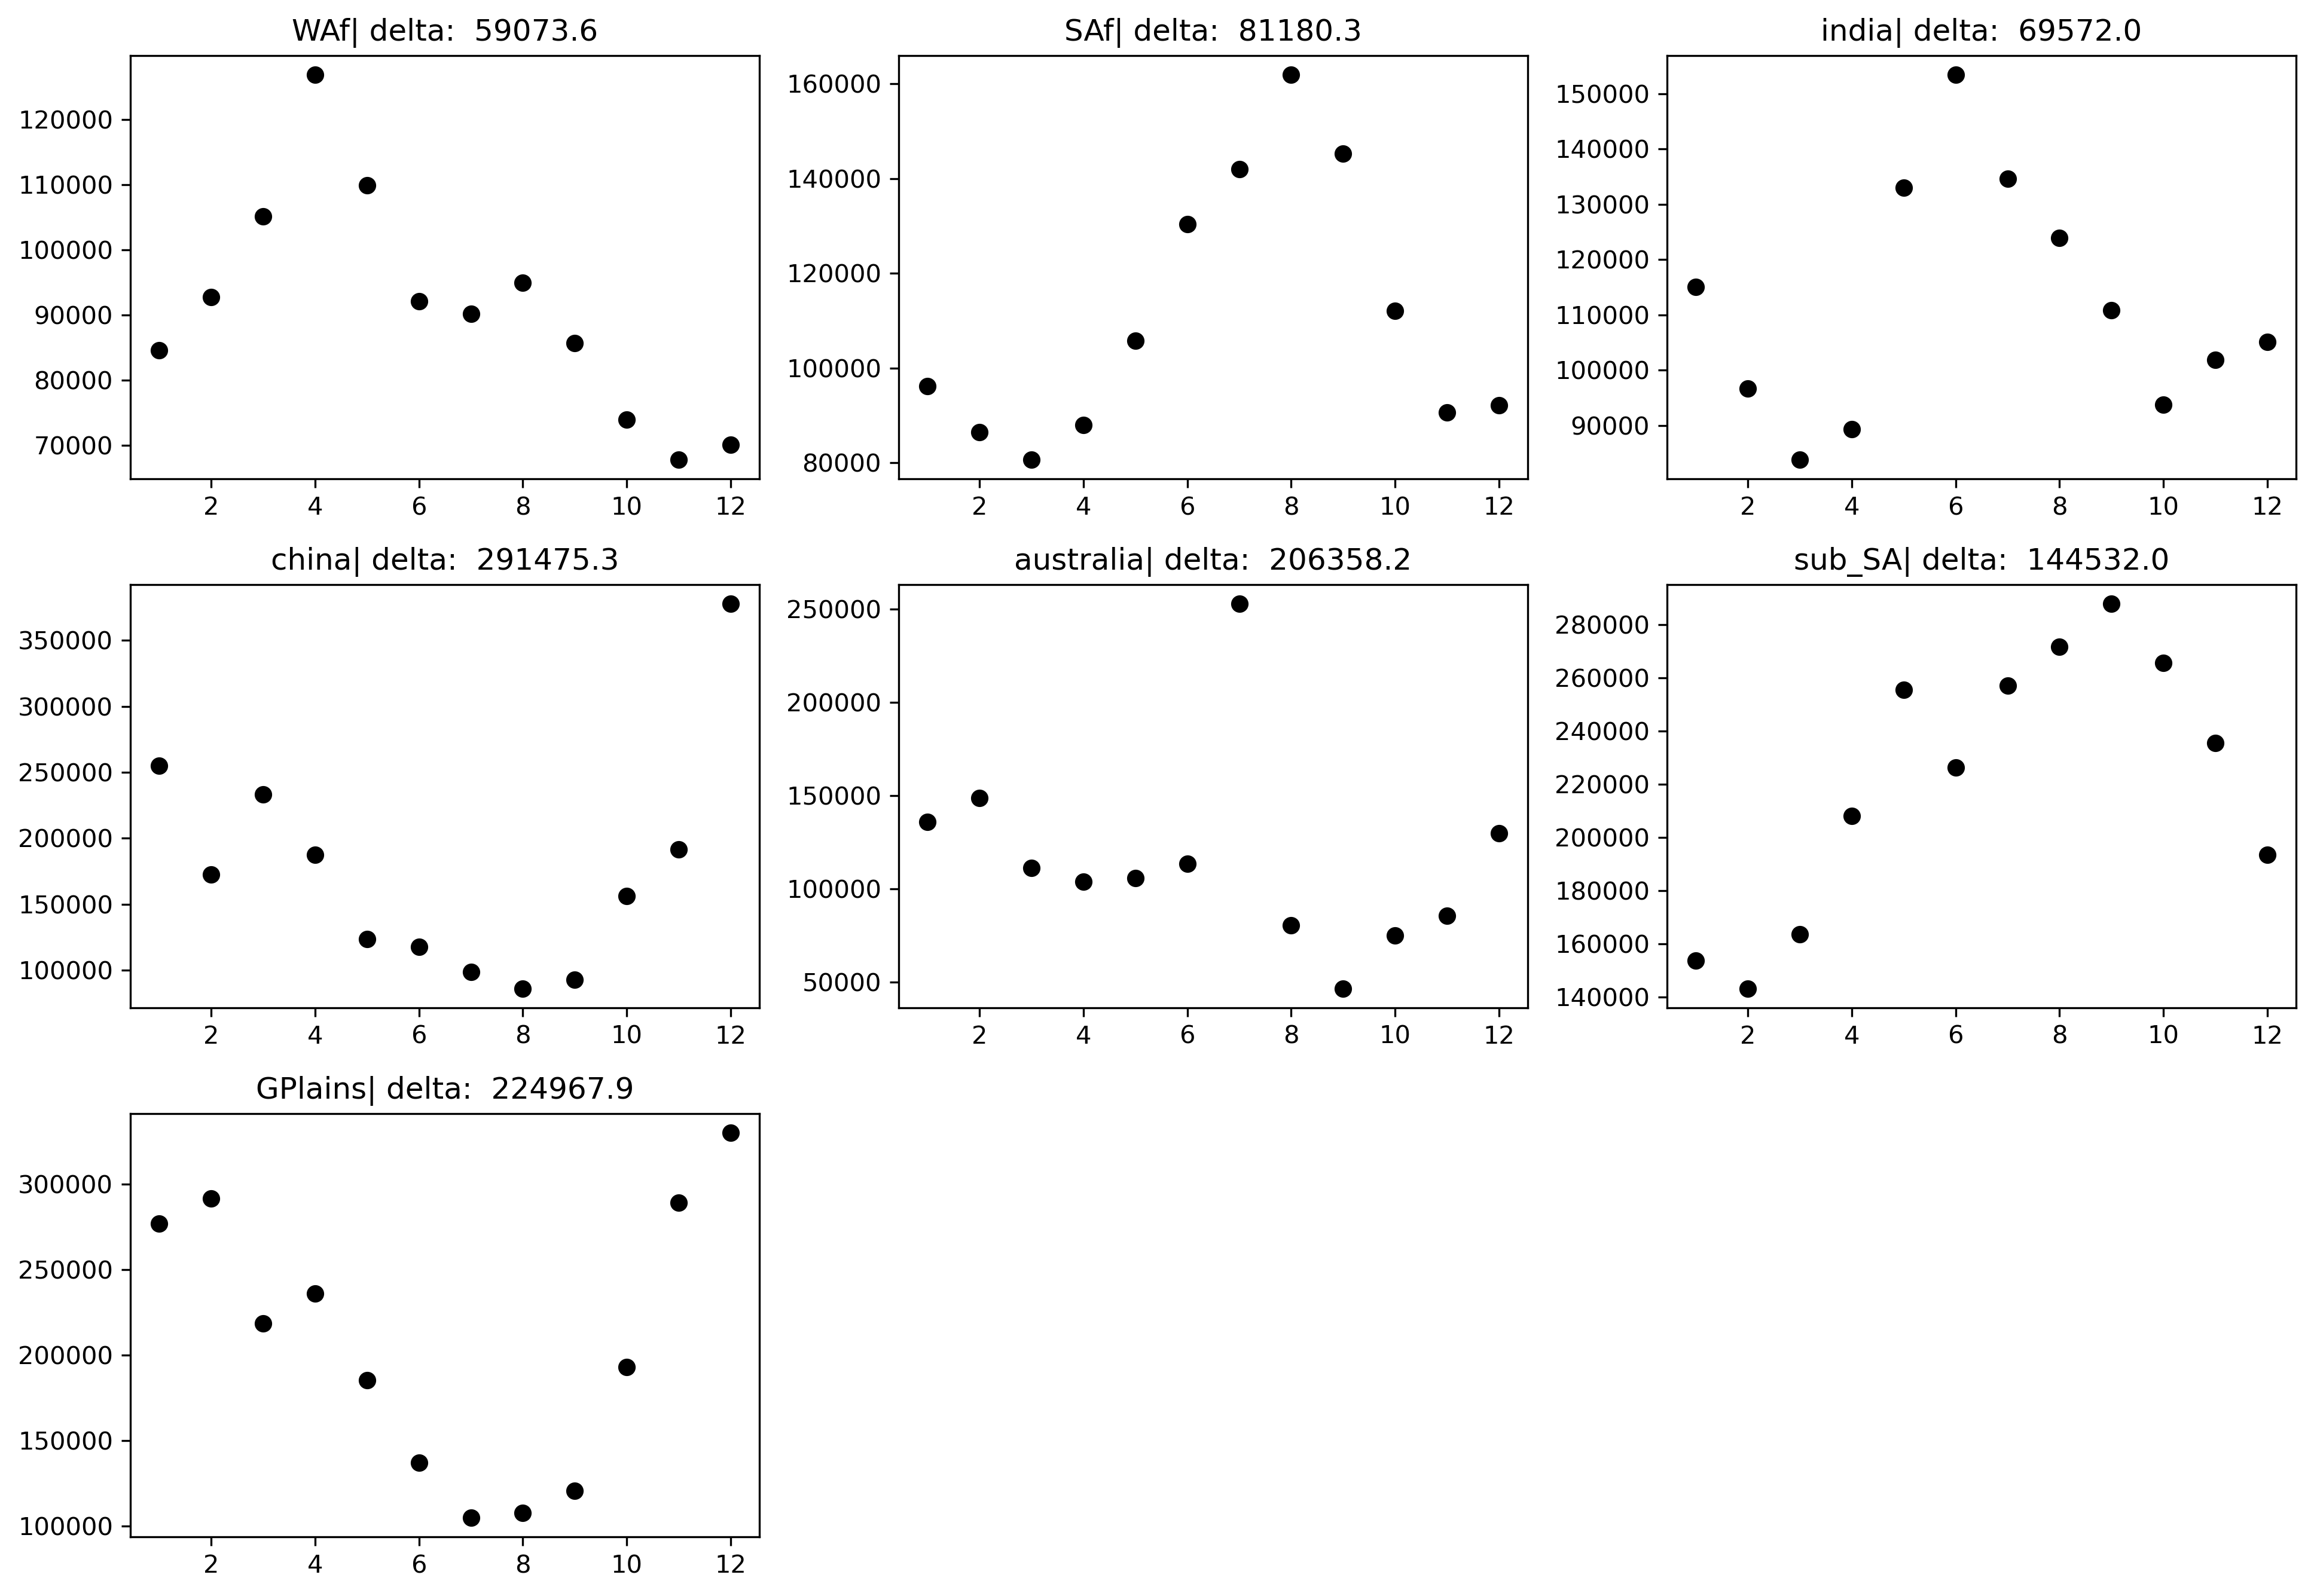

In [43]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    

    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    coll = []
    for m in range(1,13):
        pickm = pick[pick['month'] == m]
        meant =  pickm['ccs_area'].mean()
        coll.append(meant)
     
        
    ax.scatter(range(1,13),np.array(coll)-273.15, color='k')
    ax.set_title(regs + '| delta:  '+str(np.round(np.array(coll).max()-np.array(coll).min(),1)))
plt.tight_layout()
f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_storm_area.jpg')

In [ ]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    

    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    coll = []
    for m in range(1,13):
        pickm = pick[pick['month'] == m]
        meant =  pickm['meantb'].mean()
        coll.append(meant)
     
        
    ax.scatter(range(1,13),np.array(coll)-273.15, color='k')
    ax.set_title(regs + '| delta:  '+str(np.round(np.array(coll).max()-np.array(coll).min(),1)))
plt.tight_layout()
f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_storm_meant.jpg')

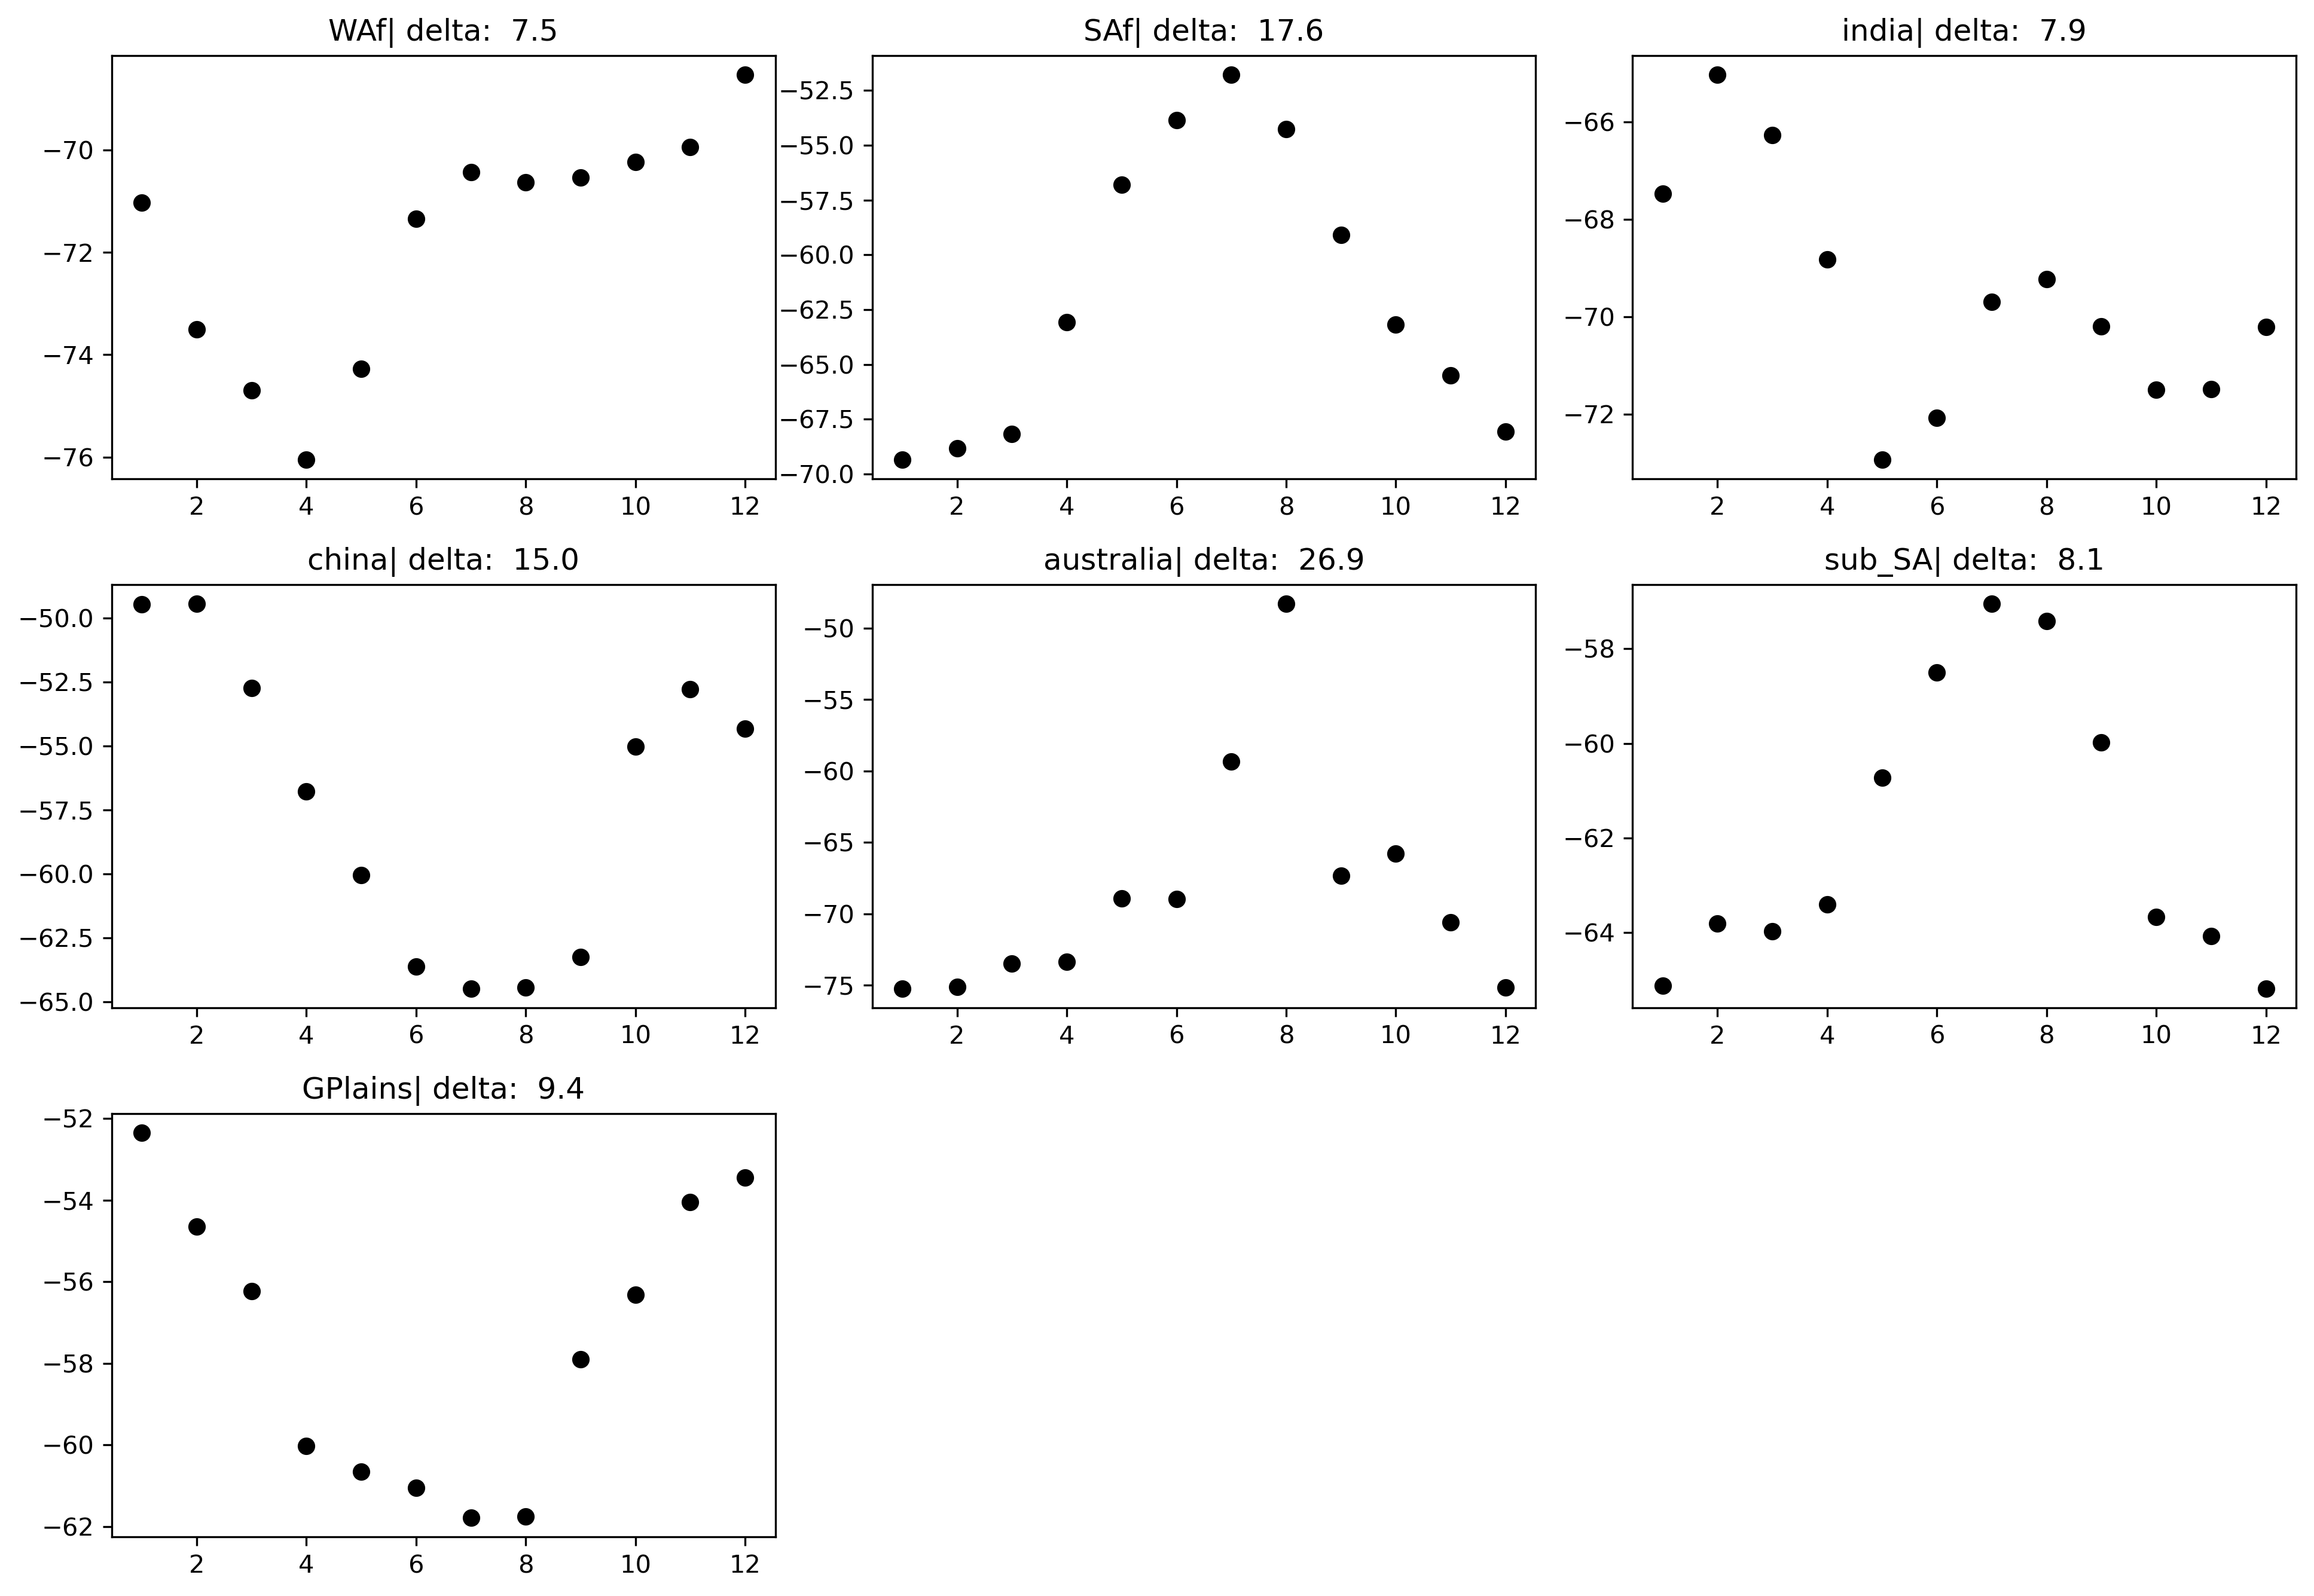

In [36]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    

    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    coll = []
    for m in range(1,13):
        pickm = pick[pick['month'] == m]
        meant =  pickm['mintb'].mean()
        coll.append(meant)
     
        
    ax.scatter(range(1,13),np.array(coll)-273.15, color='k')
    ax.set_title(regs + '| delta:  '+str(np.round(np.array(coll).max()-np.array(coll).min(),1)))
plt.tight_layout()
f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_storm_mint.jpg')

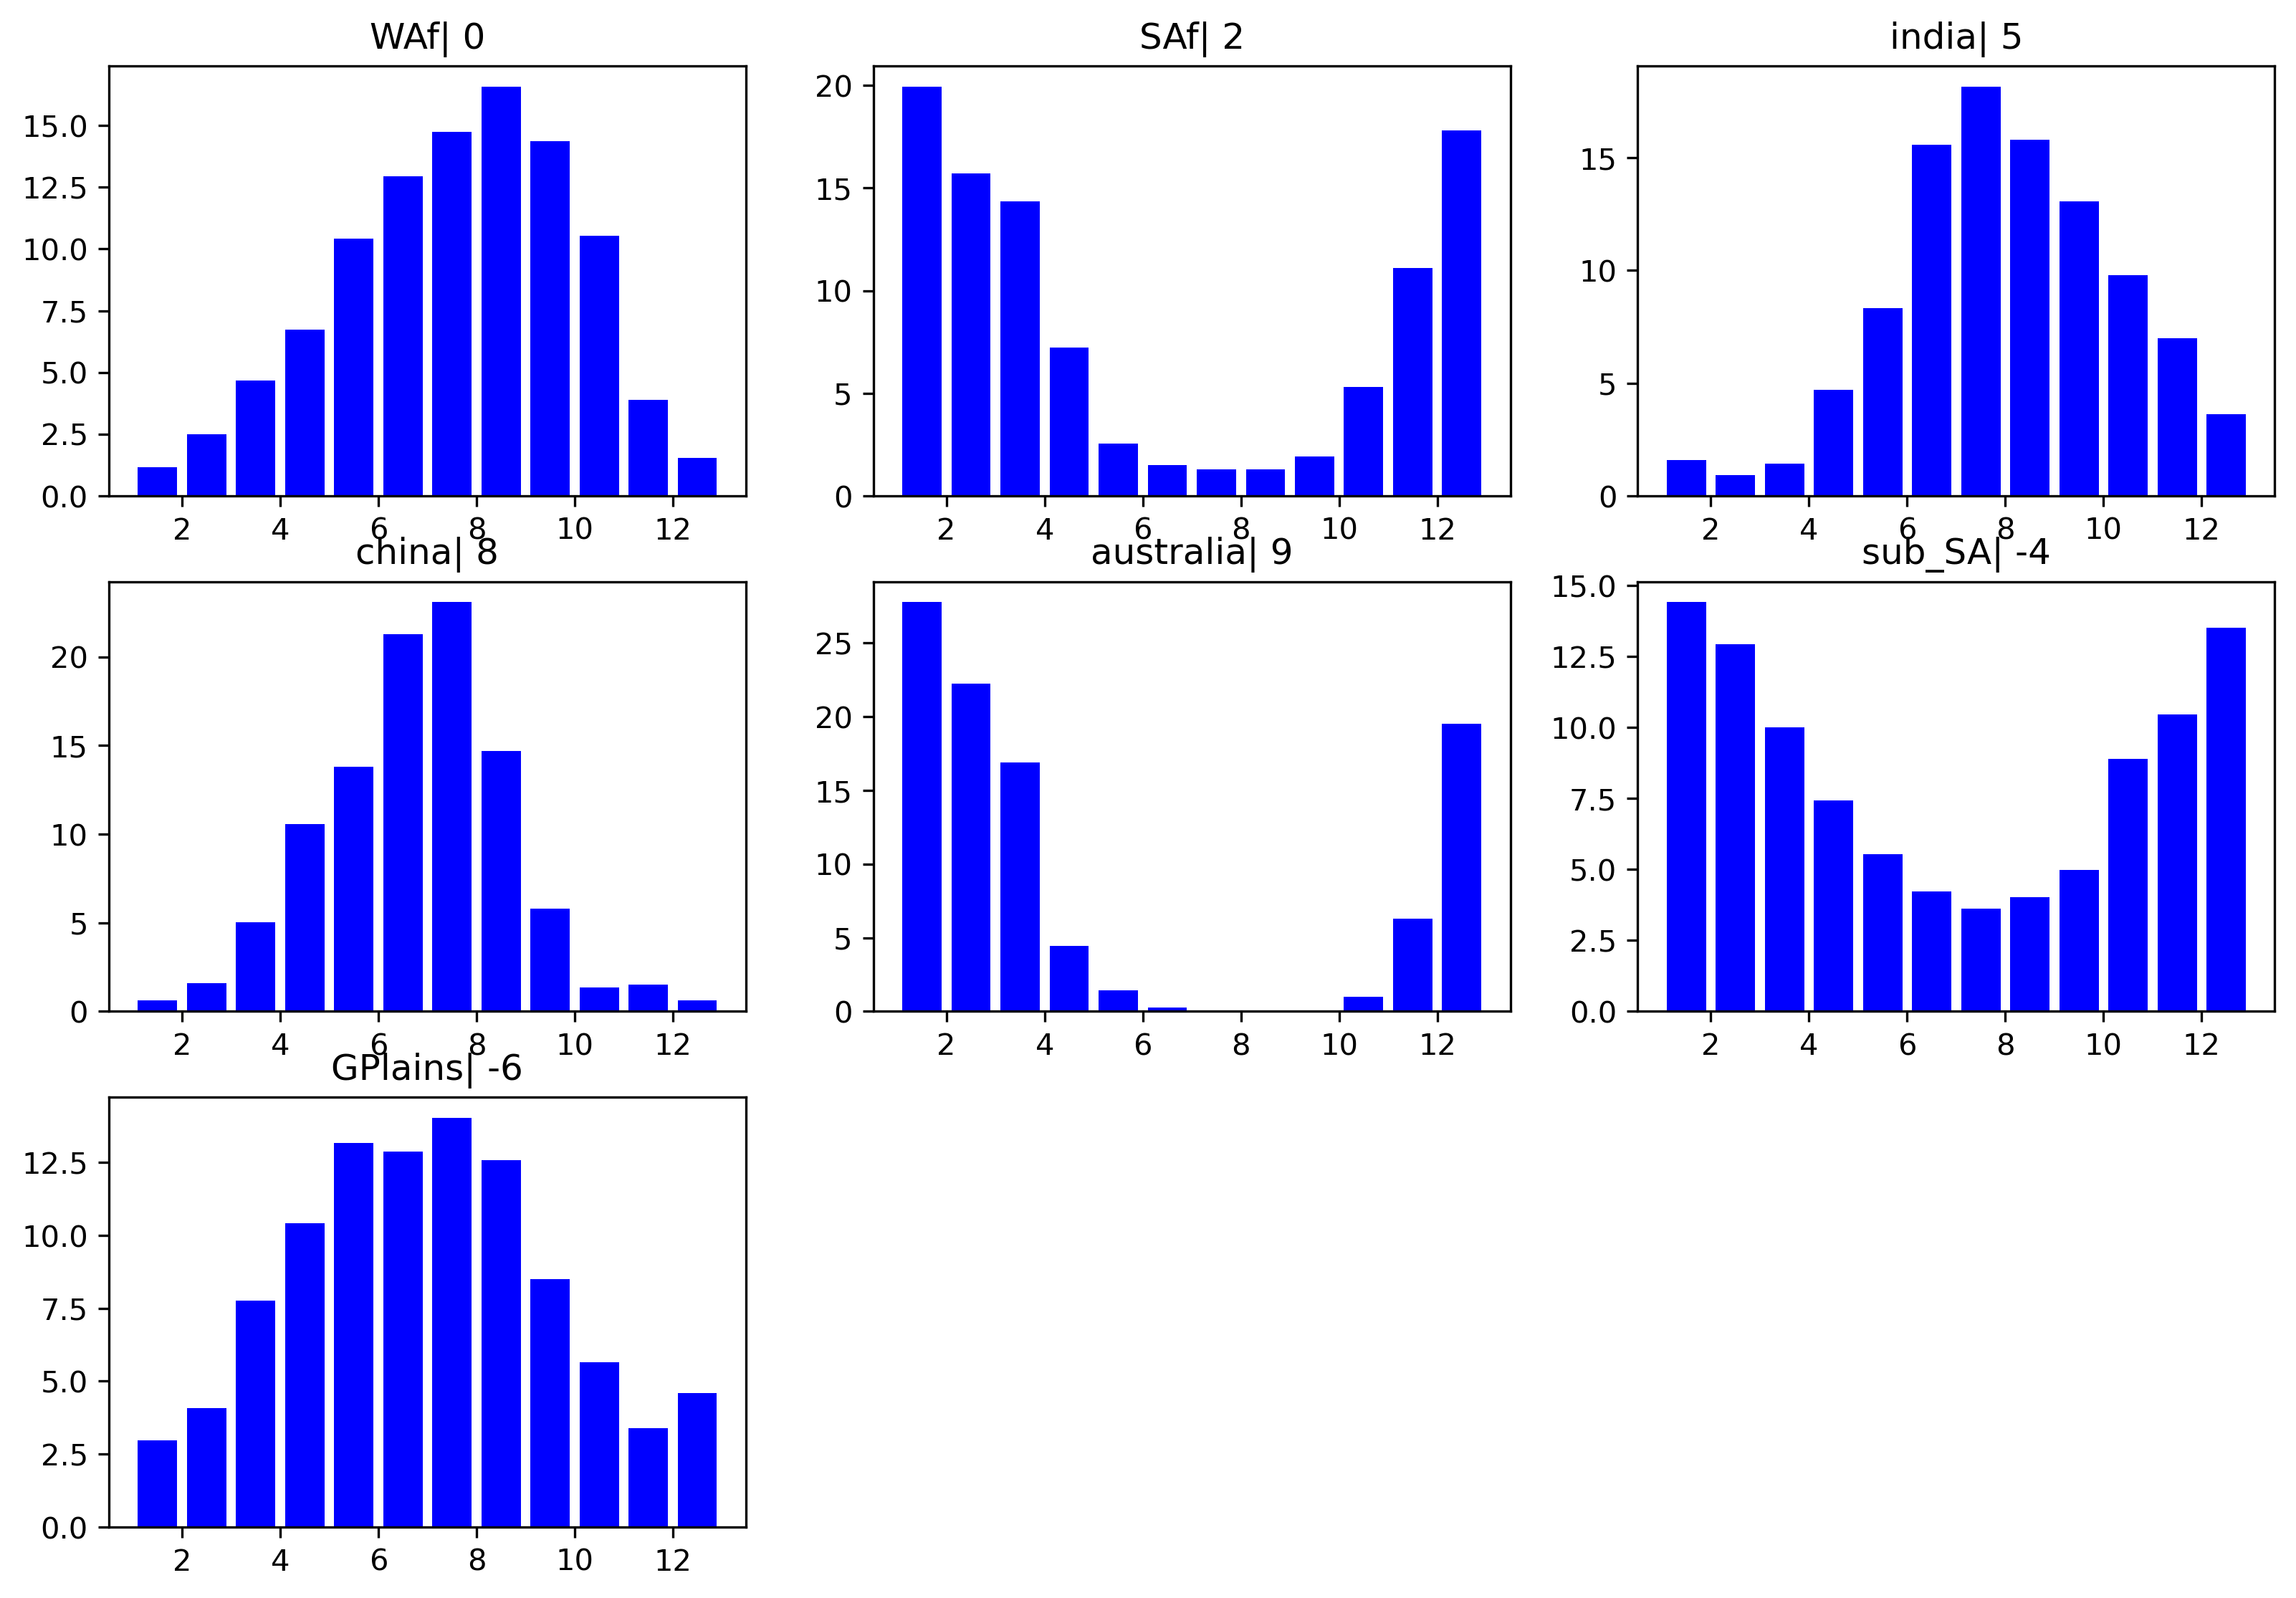

In [41]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    hist_freq, hist_count, bin_edge = u_stats.histo_frequency(pick['month'], bins=np.arange(1,14))
    #print(np.unique(pick['hour']))
    mid_bin = bin_edge[0:-1] + (bin_edge[1::]-bin_edge[0:-1])/2
    #m_bin = mid_bin - (MREGIONS[regs])[2]
    #print(mid_bin)
    colors = ['b']*24
#     ispos = int(np.where(mid_bin==18.5)[0])
#     secpos = int(np.where(mid_bin==13.5)[0])
#     firstpos = int(np.where(mid_bin==10.5)[0])
#     #minpos = ispos-(MREGIONS[regs])[2]
#     #ipdb.set_trace()
#     minpos = ispos-(MREGIONS[regs])[2]
#     miinpos = firstpos - (MREGIONS[regs])[2]
#     miiinpos = secpos - (MREGIONS[regs])[2]
#     print(minpos)
#     if minpos == 24:
#         minpos=0
    
#     colors[minpos] = 'r'
#     colors[miinpos] = 'turquoise'
#     colors[miiinpos] = 'purple'
    ax.bar(mid_bin,hist_freq, align='center', color=colors)
    ax.set_title(regs + '| '+str((MREGIONS[regs])[2]))
f.savefig('/home/ck/Desktop/lmcs/seasonal_cycle_stormNB.jpg')

18
16
13
10
9
22
24


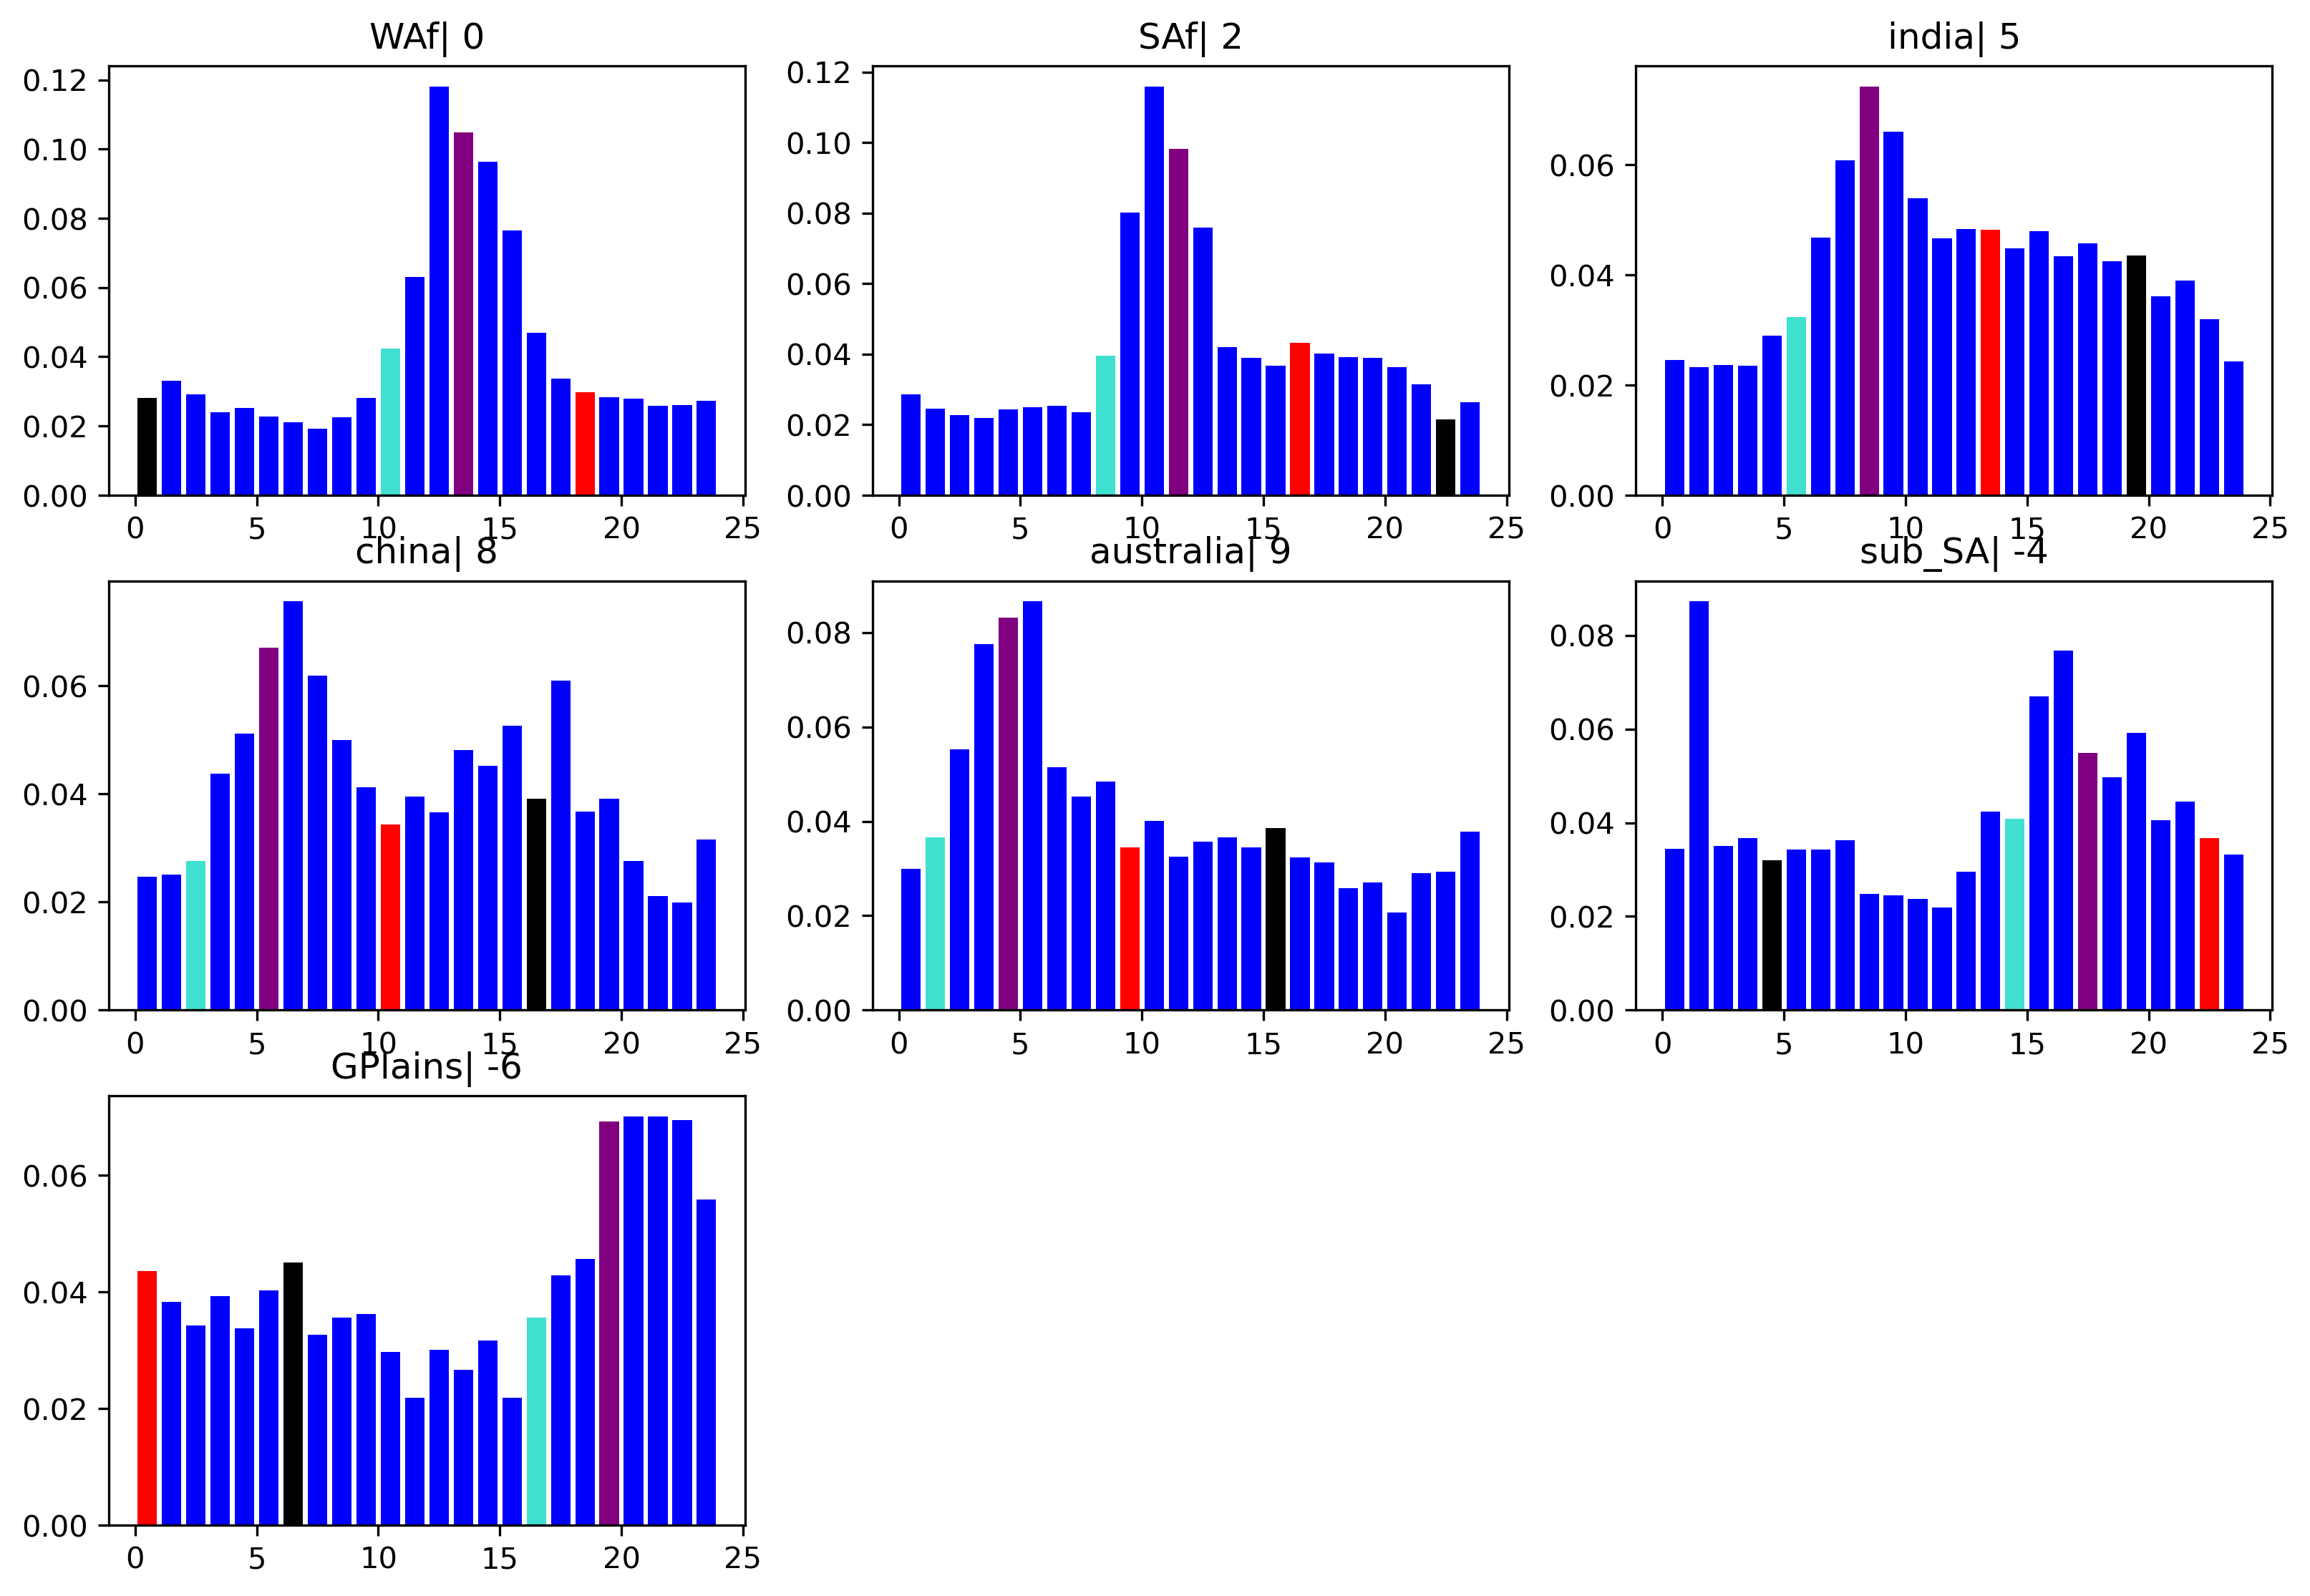

In [14]:
f= plt.figure(figsize=(13,9), dpi=300)
for ids, regs in enumerate(MREGIONS.keys()):
    ax = f.add_subplot(3,3,ids+1)
    
    pick = rdics[regs]
    hist_freq, hist_count, bin_edge = u_stats.histo_frequency(pick['init_hour'], bins=np.arange(0,25))
    #print(np.unique(pick['hour']))
    mid_bin = bin_edge[0:-1] + (bin_edge[1::]-bin_edge[0:-1])/2
    #m_bin = mid_bin - (MREGIONS[regs])[2]
    #print(mid_bin)
    colors = ['b']*24
    ispos = int(np.where(mid_bin==18.5)[0])
    secpos = int(np.where(mid_bin==13.5)[0])
    firstpos = int(np.where(mid_bin==10.5)[0])
    thirdpos = int(np.where(mid_bin==0.5)[0])
    #minpos = ispos-(MREGIONS[regs])[2]
    #ipdb.set_trace()
    minpos = ispos-(MREGIONS[regs])[2]
    miinpos = firstpos - (MREGIONS[regs])[2]
    miiinpos = secpos - (MREGIONS[regs])[2]
    midnightpos = thirdpos - (MREGIONS[regs])[2]
    print(minpos)
    if minpos == 24:
        minpos=0
    
    colors[minpos] = 'r'
    colors[miinpos] = 'turquoise'
    colors[miiinpos] = 'purple'
    colors[midnightpos] = 'k'
    ax.bar(mid_bin,hist_freq, align='center', color=colors)
    ax.set_title(regs + '| '+str((MREGIONS[regs])[2]))
